## 라이브러리

In [72]:
import os
import time
import copy
import random
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# import dgl
import torch
import torch_sparse
import torch.nn.functional as F

from torch import nn
from torch import Tensor
from torch.nn import Linear
import torch.optim as optim
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.loader import DataLoader
# from dgl.nn.pytorch import GraphConv
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import wasserstein_distance, pearsonr, spearmanr

from typing import Optional, Tuple
from torch_sparse import SparseTensor, matmul
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.gcn_conv import gcn_norm

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)


## 함수

In [73]:
class GCN_Body(nn.Module):
    def __init__(self, nfeat, nhid, dropout):
        super(GCN_Body, self).__init__()
        self.gc1 = GCNConv(nfeat, nhid)
        self.gc2 = GCNConv(nhid, nhid)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x = F.relu(self.gc1(x, edge_index))
        x = self.dropout(x)
        x = self.gc2(x, edge_index)
        return x  
    
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.body = GCN_Body(nfeat,nhid,dropout)
        self.fc = nn.Linear(nhid,nclass)

    def forward(self, x, edge_index):
        x = self.body(x, edge_index)
        x = self.fc(x)
        return x

# 나중에 수정 필요함
class GAT_body(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT_body, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = F.elu
        # input projection (no residual)
        self.gat_layers.append(GATConv(
            in_dim, num_hidden, heads[0],
            feat_drop, attn_drop, negative_slope, False, self.activation))
        
        # hidden layers
        for l in range(1, num_layers):
            # due to multi-head, the in_dim = num_hidden * num_heads
            self.gat_layers.append(GATConv(
                num_hidden * heads[l-1], num_hidden, heads[l],
                feat_drop, attn_drop, negative_slope, residual, self.activation))
        
        # output projection
        self.gat_layers.append(GATConv(
            num_hidden * heads[-2], num_hidden, heads[-1],
            feat_drop, attn_drop, negative_slope, residual, None))
    
    def forward(self, g, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](g, h).flatten(1)
        
        # output projection
        logits = self.gat_layers[-1](g, h).mean(1)

        return logits

class GAT(nn.Module):
    def __init__(self,
                 num_layers,
                 in_dim,
                 num_hidden,
                 num_classes,
                 heads,
                 feat_drop,
                 attn_drop,
                 negative_slope,
                 residual):
        super(GAT, self).__init__()

        self.body = GAT_body(num_layers, in_dim, num_hidden, heads, feat_drop, attn_drop, negative_slope, residual)
        self.fc = nn.Linear(num_hidden,num_classes)
    
    def forward(self, g, inputs):
        logits = self.body(g,inputs)
        logits = self.fc(logits)

        return logits

def get_model(model, nfeat,
              num_hidden=64, dropout=0.5, num_heads=1, num_layers=1, num_out_heads=1, attn_drop=0.0, negative_slope=0.2, residual=False):
    if model == "GCN":
        model = GCN_Body(nfeat, num_hidden, dropout)
    elif model == "GAT":
        heads = ([num_heads] * num_layers) + [num_out_heads]
        model = GAT_body(num_layers, nfeat, num_hidden, heads, dropout, attn_drop, negative_slope, residual)
    else:
        raise ValueError("Model not implemented")
    return model
   
def fair_metric(output, labels, sens, idx):
    val_y = labels[idx].cpu().numpy()
    idx_s0 = sens.cpu().numpy()[idx.cpu().numpy()]==0
    idx_s1 = sens.cpu().numpy()[idx.cpu().numpy()]>0

    idx_s0_y1 = np.bitwise_and(idx_s0,val_y>0)
    idx_s1_y1 = np.bitwise_and(idx_s1,val_y>0)

    pred_y = (output[idx].squeeze()>0.5).type_as(labels).cpu().numpy()

    parity = abs(sum(pred_y[idx_s0])/sum(idx_s0)-sum(pred_y[idx_s1])/sum(idx_s1))
    equality = abs(sum(pred_y[idx_s0_y1])/sum(idx_s0_y1)-sum(pred_y[idx_s1_y1])/sum(idx_s1_y1))

    return parity, equality

def accuracy(output, labels):
    output = output.squeeze()
    preds = (output>0).type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    
    return correct / len(labels)

def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Unsupported value encountered.')

def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]

    return 2*(features - min_values).div(max_values-min_values) - 1


In [74]:
def fair_metric_regression(output, labels, sens):
    y_g0 = output[sens == 0]
    y_g1 = output[sens == 1]
    
    # 그룹별 MSE 차이
    mse_g0 = mean_squared_error(labels[sens == 0].cpu().numpy(), y_g0.cpu().numpy()) if len(y_g0) > 0 else 0.0
    mse_g1 = mean_squared_error(labels[sens == 1].cpu().numpy(), y_g1.cpu().numpy()) if len(y_g1) > 0 else 0.0
    mse_diff = abs(mse_g0 - mse_g1)
    
    # Wasserstein 거리: 1D 배열로 변환
    w_dist = wasserstein_distance(
        y_g0.cpu().numpy().flatten(), 
        y_g1.cpu().numpy().flatten()
    ) if len(y_g0) > 0 and len(y_g1) > 0 else 0.0
    
    return mse_diff, w_dist

In [75]:
# def get_sen(sens, idx_sens_train):
#     sens_zeros = torch.zeros_like(sens)
#     sens_1 = sens 
#     sens_0 = (1 - sens) 
    
#     sens_1[idx_sens_train] = sens_1[idx_sens_train] / len(sens_1[idx_sens_train])
#     sens_0[idx_sens_train] = sens_0[idx_sens_train] / len(sens_0[idx_sens_train])

#     sens_zeros[idx_sens_train] = sens_1[idx_sens_train] - sens_0[idx_sens_train]
#     sen_mat = torch.unsqueeze(sens_zeros, dim=0)
#     return sen_mat

def get_sen(sens, idx_sens_train):
    num_classes = 2  # binary sensitive attribute assumed
    one_hot = F.one_hot(sens.long(), num_classes=num_classes).float()  # (N, 2)

    # training 노드에 대해서만 정규화
    group_sums = one_hot[idx_sens_train].sum(dim=0, keepdim=True)  # (1, 2)
    group_sums[group_sums == 0] = 1  # 0으로 나누는 것 방지

    one_hot[idx_sens_train] = one_hot[idx_sens_train] / group_sums  # group-normalized

    return one_hot  # shape: (N, 2)

# def check_sen(edge_index, sen):
#     nnz = edge_index.nnz()
#     deg = torch.eye(edge_index.sizes()[0]).cuda()
#     adj = edge_index.to_dense()
#     lap = (sen.t() @ sen).to_dense()
#     lap2 = deg - adj
#     diff = torch.sum(torch.abs(lap2-lap)) / nnz
#     assert diff < 0.000001, f'error: {diff} need to make sure L=B^TB'


## 데이터셋 함수 및 설정

In [77]:
# 데이터셋 로드 함수
def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

def load_dataset(dataset, sens_attr,predict_attr, path="./dataset/pokec/", 
               label_number=1000, sens_number=500, test_idx=False, seed=1127):
    """Load data"""
    print('Loading {} dataset from {}'.format(dataset,path))

    idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove("user_id")

    header.remove(sens_attr)
    header.remove(predict_attr)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values
    
    # build graph
    idx = np.array(idx_features_labels["user_id"], dtype=int)
    idx_map = {j: i for i, j in enumerate(idx)}

    # edges_unordered = np.genfromtxt(os.path.join(path,"{}_relationship.txt".format(dataset)), dtype=int)
    edges_unordered = np.genfromtxt(os.path.join(path, f"{dataset}_relationship.txt"), dtype=np.int64)

    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=int).reshape(edges_unordered.shape)
    mapped_edges = []
    dropped = 0
    for u, v in edges_unordered:
        u_mapped = idx_map.get(u)
        v_mapped = idx_map.get(v)
        if u_mapped is not None and v_mapped is not None:
            mapped_edges.append((u_mapped, v_mapped))
        else:
            dropped += 1

    print(f"[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: {dropped}")
    edges = np.array(mapped_edges, dtype=int)

    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # features = normalize(features)
    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    # adj = sparse_mx_to_torch_sparse_tensor(adj)

    random.seed(seed)
    label_idx = np.where(labels>=0)[0]
    random.shuffle(label_idx)

    idx_train = label_idx[:min(int(0.5 * len(label_idx)),label_number)]
    idx_val = label_idx[int(0.5 * len(label_idx)):int(0.75 * len(label_idx))]
    if test_idx:
        idx_test = label_idx[label_number:]
        idx_val = idx_test
    else:
        idx_test = label_idx[int(0.75 * len(label_idx)):]

    sens = idx_features_labels[sens_attr].values

    sens_idx = set(np.where(sens >= 0)[0])
    idx_test = np.asarray(list(sens_idx & set(idx_test)))
    sens = torch.FloatTensor(sens)
    idx_sens_train = list(sens_idx - set(idx_val) - set(idx_test))
    random.seed(seed)
    random.shuffle(idx_sens_train)
    idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    
    # random.shuffle(sens_idx)

    if dataset == 'nba':
        features = feature_norm(features)

    return adj, features, labels, idx_train, idx_val, idx_test, sens,idx_sens_train

def is_symmetric(m):
    '''
    Judge whether the matrix is symmetric or not.
    :param m: Adjacency matrix(Array)
    '''
    res = np.int64(np.triu(m).T == np.tril(m))
    # if np.where(res==0)[0] != []:
    if np.where(res == 0)[0].size > 0:
        raise ValueError("The matrix is not symmetric!")
    else:
        pass
    
def symetric_normalize(m, half: bool):
    '''
    Symmetrically normalization for adjacency matrix
    :param m: (Array) Adjacency matrix
    :param half: (bool) whether m is triu or full
    :return: (Array) An symmetric adjacency matrix
    '''
    if not half:
        is_symmetric(m)
    else:
        m = m + m.T - np.diag(np.diagonal(m))

    hat_m = m + np.eye(m.shape[0])
    D = np.sum(hat_m, axis=1)
    D = np.diag(D)

    # D = np.power(D, -0.5)
    with np.errstate(divide='ignore'):
        D = np.power(D, -0.5)
        D[np.isinf(D)] = 0

    D[np.isinf(D)] = 0
    sn_m = np.matmul(np.matmul(D, hat_m), D)
    return sn_m

def sp2sptensor(m):
    # sparse_m = sp.coo_matrix(m).astype(np.float)
    sparse_m = sp.coo_matrix(m).astype(np.float64)
    # indices = torch.from_numpy(np.vstack((sparse_m.row, sparse_m.col)).astype(int))
    indices = torch.from_numpy(np.vstack((sparse_m.row, sparse_m.col))).long()
    values = torch.from_numpy(sparse_m.data)
    shape = torch.Size(sparse_m.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

class German:
    def __init__(self, path):
        if not os.path.exists(path):
            raise ValueError("Data path doesn't exist!")
        else:
            self.data_path = path
        self.raw_data = self._node_process()
        self.A_tensor, self.A = self._edge_process()
        self.senIdx, self.sen_vals, self.trainIdxtensor, self.valIdxTensor, self.testIdxTensor, self.features, self.labels = self._split_data()

    def _node_process(self):
        filenames = os.listdir(self.data_path)

        for file in filenames:
            if os.path.splitext(file)[1] != '.csv':
                continue
            else:
                df_data = pd.read_csv(os.path.join(self.data_path, file))

                # modify str feature
                # df_data['GoodCustomer'].replace(-1, 0, inplace=True)
                df_data['GoodCustomer'] = df_data['GoodCustomer'].replace(-1, 0).astype(int)

                # df_data['Gender'].replace('Male', 1, inplace=True)
                # df_data['Gender'].replace('Female', 0, inplace=True)
                gender_map = {'Female': 0, 'Male': 1}
                df_data['Gender'] = df_data['Gender'].map(gender_map).astype(int)

                purposeList = list(df_data['PurposeOfLoan'])
                random.shuffle(purposeList)
                purposeDict = {}
                index = 0
                for pur in purposeList:
                    if purposeDict.get(pur, None) is None:
                        purposeDict[pur] = index
                        index += 1
                    else:
                        continue

                for key in purposeDict.keys():
                    # df_data['PurposeOfLoan'].replace(key, purposeDict[key], inplace=True)
                    df_data['PurposeOfLoan'] = df_data['PurposeOfLoan'].map(purposeDict).fillna(-1).astype(int)
                    
                return df_data

    def _edge_process(self):
        filenames = os.listdir(self.data_path)

        for file in filenames:
            if os.path.splitext(file)[1] != '.txt':
                continue
            else:
                edges = np.loadtxt(os.path.join(self.data_path, file)).astype(int)

                # Adjacency
                num_dim = len(self.raw_data)
                A = np.zeros((num_dim, num_dim))
                for i in range(len(edges)):
                    A[edges[i][0]][edges[i][1]] = 1
                    A[edges[i][1]][edges[i][0]] = 1
                sym_norm_A = symetric_normalize(A, half=False)
                syn_norm_A_tensor = sp2sptensor(sym_norm_A)
                return syn_norm_A_tensor, A

    def _split_data(self):
        pos_data = self.raw_data[self.raw_data['GoodCustomer']==1]
        pos_index = list(pos_data.index)
        neg_data = self.raw_data[self.raw_data['GoodCustomer']==0]
        neg_index = list(neg_data.index)

        # shuffle the index
        random.seed(20)
        random.shuffle(pos_index)
        random.shuffle(neg_index)

        # split the data
        train_pos_idx = pos_index[:int(0.5*len(pos_index))]
        train_neg_idx = neg_index[:int(0.5*len(neg_index))]
        val_pos_idx = pos_index[int(0.5*len(pos_index)): int(0.75*len(pos_index))]
        val_neg_idx = neg_index[int(0.5*len(neg_index)): int(0.75*len(neg_index))]
        test_pos_idx = pos_index[int(0.75*len(pos_index)):]
        test_neg_idx = neg_index[int(0.75*len(neg_index)):]

        trainIdx = train_pos_idx + train_neg_idx
        random.shuffle(trainIdx)
        valIdx = val_pos_idx + val_neg_idx
        random.shuffle(valIdx)
        testIdx = test_pos_idx + test_neg_idx
        random.shuffle(testIdx)

        assert len(trainIdx)+len(valIdx)+len(testIdx) == len(self.raw_data), "Missing data or leaking data!"

        feature_cols = list(self.raw_data.columns)
        feature_cols.remove('GoodCustomer')
        sen_idx = feature_cols.index('Gender')
        sen_vals = self.raw_data['Gender'].values.astype(int)
        feature_data = self.raw_data[feature_cols]
        labels = self.raw_data['GoodCustomer']

        # transform to tensor
        trainIdxTensor = torch.LongTensor(trainIdx)
        valIdxTensor = torch.LongTensor(valIdx)
        testIdxTensor = torch.LongTensor(testIdx)
        featuredata = torch.FloatTensor(np.array(feature_data))
        labels = torch.LongTensor(np.array(labels))

        return sen_idx, sen_vals, trainIdxTensor, valIdxTensor, testIdxTensor, featuredata, labels

    def get_index(self):
        return [self.trainIdxtensor, self.valIdxTensor, self.testIdxTensor]

    def get_raw_data(self):
        return [self.features, self.A_tensor, self.labels]

    def generate_counterfactual_perturbation(self, data):
        '''
        Generate counterfactual data by flipping sensitive attribute.
        :param data: Tensor
        :return: counterfactual data
        '''
        feature_data = copy.deepcopy(data)
        feature_data[:, self.senIdx] = 1 - feature_data[:, self.senIdx]
        return feature_data

    def generate_node_perturbation(self, prob: float, sen: bool = False):
        '''
        Perturbing node attributes, except for sensitive attributes.
        :param prob: portion of perturbed data
        :return: perturbed data
        '''
        feature_data = copy.deepcopy(self.features)
        r = np.random.binomial(n=1, p=prob, size=feature_data.numpy().shape)
        for i in range(len(feature_data)):
            r[i][self.senIdx] = 0
        noise = np.multiply(r, np.random.normal(0., 1., r.shape))
        noise_tensor = torch.FloatTensor(noise)
        x_hat = feature_data + noise_tensor

        if sen:
            x_hat = self.generate_counterfactual_perturbation(x_hat)
        return x_hat

    def generate_struc_perturbation(self, drop_prob: float, tensor: bool = True):
        A = copy.deepcopy(self.A)
        half_A = np.triu(A)
        row, col = np.nonzero(half_A)
        idx_perturb = np.random.binomial(n=1, p=1-drop_prob, size=row.shape)
        broken_edges = np.where(idx_perturb==0)[0]
        for idx in broken_edges:
            half_A[row[idx]][col[idx]] = 0
        new_A = symetric_normalize(half_A, half=True)
        if tensor:
            new_A = sp2sptensor(new_A)
        return new_A

def load_dataset_unified(dataset, sens_attr, predict_attr, path="./dataset/", 
                         label_number=1000, sens_number=500, test_idx=False, seed=1127):
    
    if dataset.lower() != 'german':
        full_path = path
        # full_path = os.path.join(path, "pokec")
        return load_dataset(dataset, sens_attr, predict_attr, full_path, label_number, sens_number, test_idx, seed)

    elif dataset.lower() == 'german':
        full_path = path
        # full_path = os.path.join(path, "german")
        german_data = German(full_path)

        adj = german_data.A_tensor
        features = german_data.features
        labels = german_data.labels
        sens = torch.FloatTensor(german_data.sen_vals)
        idx_train, idx_val, idx_test = german_data.get_index()

        # 민감 속성 학습용 인덱스 (val/test 제외)
        all_idx = set(range(len(sens)))
        sens_idx = set(np.where(sens.numpy() >= 0)[0])
        idx_sens_train = list(sens_idx - set(idx_val.numpy()) - set(idx_test.numpy()))
        random.seed(seed)
        random.shuffle(idx_sens_train)
        idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])

        return adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train

    else:
        raise ValueError(f"Unsupported dataset: {dataset}")


In [78]:
# 데이터셋 설정
dataset_config = {
    'region_job_r': {
        'path': "./dataset/pokec",
        'dataset': 'region_job', # Pokec_z
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'region', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_z_Region'
    },

    'region_job_g': {
        'path': "./dataset/pokec",
        'dataset': 'region_job',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'gender', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_z_Gender'
    },

    'region_job_2_r': {
        'path': "./dataset/pokec",
        'dataset': 'region_job_2',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'region', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_n_Region'
    },

    'region_job_2_g': {
        'path': "./dataset/pokec",
        'dataset': 'region_job_2',
        'predict_attr': 'completion_percentage',  # completion_percentage: 프로필을 얼마나 채웠는가 (%). 자발적 행동의 간접 지표.
        'sens_attr': 'gender', # gender
        'label_number': 500,
        'sens_number': 200,
        'test_idx': False,
        'dn': 'Pokec_n_Gender'
    },

    'nba_p': {
        'path': "./dataset/NBA",
        'dataset': 'nba',
        # PIE (Player Impact Estimate): 통합 퍼포먼스 지표, 퍼포먼스에 대한 차별 여부 확인 가능
        # MPG (Minutes Per Game): 출전 시간 → 팀의 코치 결정, 제도적 편향 가능성
        'predict_attr': 'PIE',
        'sens_attr': 'country',  # AGE, palyer_height, player_weight
        'label_number': 100,
        'sens_number': 50,
        'test_idx': True,
        'dn': 'NBA(PIE)_Country'
    },

    'nba_m': {
        'path': "./dataset/NBA",
        'dataset': 'nba',
        'predict_attr': 'MPG',
        'sens_attr': 'country',
        'label_number': 100,
        'sens_number': 50,
        'test_idx': True,
        'dn': 'NBA(MPG)_Country'
    },

    'german_g': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', # LoanAmount(대출 금액), LoanRateAsPercentOfIncome(소득대비상환비율), YearsAtCurrentHome(거주연수)
        'sens_attr': 'Gender', # Gender, ForeignWorker, Single(독신여부), HasTelephone(전화기보유여부), OwnsHouse(주택소유여부), Unemployed(실직상태여부) Age(고령자로 나눠서 가능) 등등등..
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Gender'
    },

    'german_f': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount',
        'sens_attr': 'ForeignWorker',
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_ForeignWorker'
    },

    'german_s': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'Single', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Single'
    },

    'german_t': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'HasTelephone', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_HasTelephone'
    },

    'german_h': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'OwnsHouse', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_OwnsHouse'
    },

    'german_e': {
        'path': './dataset/NIFTY',
        'dataset': 'german',
        'predict_attr': 'LoanAmount', 
        'sens_attr': 'Unemployed', 
        'label_number': None,
        'sens_number': None,
        'test_idx': None,
        'dn': 'German_Unemployed'
    }
}


## 데이터 분석

In [ ]:
# 데이터셋 분석: Pokec_z, Pokec_n, NBA, German 데이터셋을 분석하여 민감 속성(sensitive attribute)과 예측 속성(predict attribute)의 분포, 그래프 구조 특성(homophily 등)을 파악하고, 공정성 문제를 식별.
# 데이터셋의 특성과 공정성 문제를 이해하기 위해 다음 분석을 수행

# 데이터셋 분석 결과를 새로운 GNN 기반 공정성 모델 설계에 효과적으로 연결
# 분석에서 도출된 통찰을 모델의 공정성 메커니즘, 손실 함수, 그래프 구조 처리 방식 등에 반영
# 질문에서 제공된 데이터셋(Pokec_z, Pokec_n, NBA, German)을 분석하여 FairGNN 및 FMP와 차별화된 새로운 회귀 공정성 모델(FairRegGNN)을 설계
# FairRegGNN 모델 설계에 필요한 하이퍼파라미터(lambda1, lambda2, lambda3, group_weights)를 조정

In [16]:
def compute_graph_fairness_stats(data, edge_index):
    sens = data.sensitive_attr.cpu().numpy()
    labels = data.y.cpu().numpy()
    src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
    num_nodes = len(sens)

    print("========== Dataset Summary ==========")
    print(f"Total nodes: {num_nodes}")
    print(f"Total edges: {edge_index.shape[1]}")

    # 1. 민감 속성 분포
    g0, g1 = np.sum(sens == 0), np.sum(sens == 1)
    print("\n--- Sensitive Attribute Distribution ---")
    print(f"Group 0: {g0} ({g0/num_nodes:.2%})")
    print(f"Group 1: {g1} ({g1/num_nodes:.2%})")

    # 2. 예측값 분포
    print("\n--- Label Distribution ---")
    print(f"Overall: mean={labels.mean():.4f}, std={labels.std():.4f}")
    print(f"Group 0: mean={labels[sens==0].mean():.4f}, std={labels[sens==0].std():.4f}")
    print(f"Group 1: mean={labels[sens==1].mean():.4f}, std={labels[sens==1].std():.4f}")

    # 3. 상관관계
    pear, _ = pearsonr(sens, labels)
    spear, _ = spearmanr(sens, labels)
    print("\n--- Correlation (Sensitive vs Label) ---")
    print(f"Pearson:  {pear:.4f}")
    print(f"Spearman: {spear:.4f}")

    # 4. Homophily
    def homophily(attr):
        return np.mean(attr[src] == attr[dst])
    sens_hom = homophily(sens)
    label_hom = homophily(labels.round())  # 연속형 label인 경우 이진화
    print("\n--- Graph Homophily ---")
    print(f"Sensitive attribute homophily: {sens_hom:.4f}")
    print(f"Label homophily: {label_hom:.4f}")

    # 5. Group별 node degree
    degree = np.bincount(src, minlength=num_nodes)
    deg_g0 = degree[sens == 0]
    deg_g1 = degree[sens == 1]
    print("\n--- Node Degree (per group) ---")
    print(f"Group 0: mean={deg_g0.mean():.2f}, std={deg_g0.std():.2f}")
    print(f"Group 1: mean={deg_g1.mean():.2f}, std={deg_g1.std():.2f}")

    # 6. 이웃 구성 동질성 (각 노드 이웃 중 같은 그룹 비율 평균)
    same_group_ratios = []
    for i in range(num_nodes):
        neighbors = dst[src == i]
        if len(neighbors) > 0:
            same_ratio = np.mean(sens[neighbors] == sens[i])
            same_group_ratios.append(same_ratio)
    print("\n--- Neighborhood Composition ---")
    print(f"Average same-group neighbor ratio: {np.mean(same_group_ratios):.4f}")


In [17]:
# print(f"Dataset: {dn}")
# print(f"Total nodes: {features.shape[0]}")
# print(f"Total edges: {edge_index.shape[1]}")

# ### 1. 민감 속성 분포
# sens_np = sens.cpu().numpy()
# sens0_cnt = np.sum(sens_np == 0)
# sens1_cnt = np.sum(sens_np == 1)
# total = len(sens_np)
# print(f"Sensitive Attribute Distribution:")
# print(f" - Group 0 (A=0): {sens0_cnt} ({sens0_cnt / total:.2%})")
# print(f" - Group 1 (A=1): {sens1_cnt} ({sens1_cnt / total:.2%})")

# ### 2. 예측 대상 분포
# labels_np = labels.cpu().numpy()
# print(f"Predict Attribute Summary:")
# print(f" - Overall: mean={labels_np.mean():.4f}, std={labels_np.std():.4f}")
# print(f" - Group 0: mean={labels_np[sens_np==0].mean():.4f}, std={labels_np[sens_np==0].std():.4f}")
# print(f" - Group 1: mean={labels_np[sens_np==1].mean():.4f}, std={labels_np[sens_np==1].std():.4f}")

# # plt.figure(figsize=(6, 3))
# # sns.kdeplot(labels_np[sens_np == 0], label='Group 0')
# # sns.kdeplot(labels_np[sens_np == 1], label='Group 1')
# # plt.title(f"{dn} Dataset: Distribution by Sensitive Group")
# # plt.xlabel("Label Value")
# # plt.legend()
# # plt.grid(True)
# # plt.show()

# ### 3. 상관계수
# pear_corr, _ = pearsonr(sens_np, labels_np)
# spear_corr, _ = spearmanr(sens_np, labels_np)
# print(f"Correlation (Sensitive vs Label):")
# print(f" - Pearson:  {pear_corr:.4f}")
# print(f" - Spearman: {spear_corr:.4f}")

# ### 4. Homophily 분석
# def compute_homophily(attr_tensor, edge_index):
#     attr = attr_tensor.cpu().numpy()
#     src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
#     matches = (attr[src] == attr[dst])
#     return np.mean(matches)

# sens_homophily = compute_homophily(sens, edge_index)
# label_homophily = compute_homophily(labels, edge_index)

# print(f"Graph Homophily:")
# print(f" - Sensitive attribute homophily: {sens_homophily:.4f}")
# print(f" - Label homophily: {label_homophily:.4f}")


In [ ]:
compute_graph_fairness_stats(data, edge_index)

In [70]:
# 값 분포 확인
# pokec
df_p = pd.read_csv('./dataset/pokec/region_job_2.csv')
# df = pd.read_csv('/home/sypark/CIKM/dataset/pokec/region_job_2.csv')
col_p = 'completion_percentage' 
sen_p = 'gender' # region, gender 

# nba
df_n = pd.read_csv('./dataset/NBA/nba.csv')
col_n = 'PIE'  # PIE, MPG 
sen_n = 'country' # country

# german
df_g = pd.read_csv('./dataset/NIFTY/german.csv')
col_g = 'LoanAmount' # LoanAmount
sen_g = 'Unemployed' # Gender, ForeignWorker, Single, HasTelephone, OwnsHouse, Unemployed

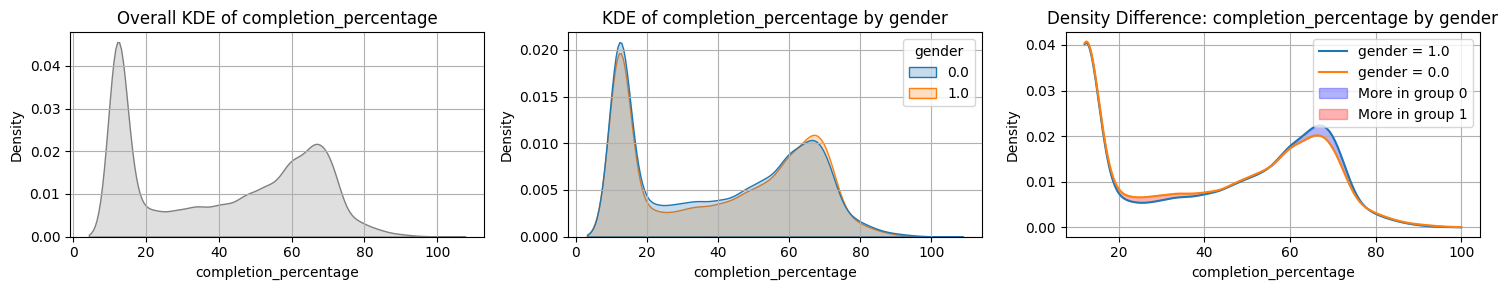

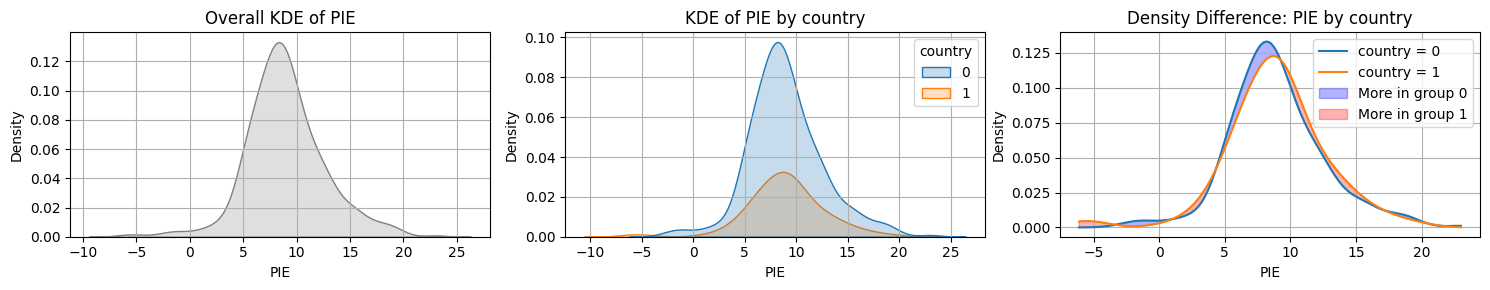

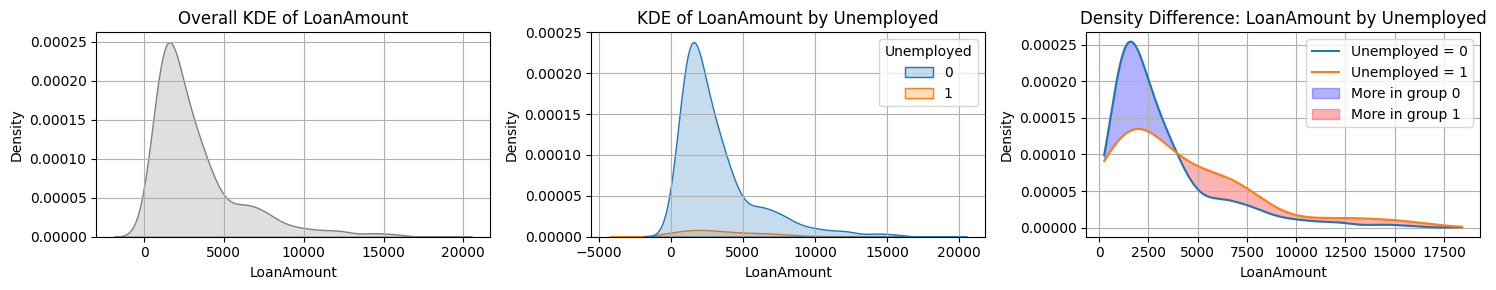

In [71]:
# print(df_p[col_p].describe())
# print(df_p[col_p].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_p, x=col_p, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_p}')
axes[0].set_xlabel(col_p)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_p, x=col_p, hue=sen_p, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_p} by {sen_p}')
axes[1].set_xlabel(col_p)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_p[sen_p].unique()
group1 = df_p[df_p[sen_p] == group_vals[0]][col_p]
group2 = df_p[df_p[sen_p] == group_vals[1]][col_p]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_p[col_p]), max(df_p[col_p]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_p} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_p} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_p} by {sen_p}')
axes[2].set_xlabel(col_p)
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# print(df_n[col_n].describe())
# print(df_n[col_n].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_n, x=col_n, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_n}')
axes[0].set_xlabel(col_n)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_n, x=col_n, hue=sen_n, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_n} by {sen_n}')
axes[1].set_xlabel(col_n)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_n[sen_n].unique()
group1 = df_n[df_n[sen_n] == group_vals[0]][col_n]
group2 = df_n[df_n[sen_n] == group_vals[1]][col_n]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_n[col_n]), max(df_n[col_n]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_n} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_n} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_n} by {sen_n}')
axes[2].set_xlabel(col_n)
axes[2].set_ylabel('Density')
axes[2].legend(loc='best')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# print(df_g[col_g].describe())
# print(df_g[col_g].value_counts())

fig, axes = plt.subplots(1, 3, figsize=(15, 3))  # 1행 3열
sns.kdeplot(data=df_g, x=col_g, fill=True, ax=axes[0], color='gray')
axes[0].set_title(f'Overall KDE of {col_g}')
axes[0].set_xlabel(col_g)
axes[0].set_ylabel('Density')
axes[0].grid(True)

sns.kdeplot(data=df_g, x=col_g, hue=sen_g, fill=True, ax=axes[1])
axes[1].set_title(f'KDE of {col_g} by {sen_g}')
axes[1].set_xlabel(col_g)
axes[1].set_ylabel('Density')
axes[1].grid(True)

group_vals = df_g[sen_g].unique()
group1 = df_g[df_g[sen_g] == group_vals[0]][col_g]
group2 = df_g[df_g[sen_g] == group_vals[1]][col_g]
kde1 = gaussian_kde(group1)
kde2 = gaussian_kde(group2)
x_range = np.linspace(min(df_g[col_g]), max(df_g[col_g]), 1000)
y1 = kde1(x_range)
y2 = kde2(x_range)

axes[2].plot(x_range, y1, label=f'{sen_g} = {group_vals[0]}')
axes[2].plot(x_range, y2, label=f'{sen_g} = {group_vals[1]}')
axes[2].fill_between(x_range, y1, y2, where=(y1 > y2), color='blue', alpha=0.3, label='More in group 0')
axes[2].fill_between(x_range, y1, y2, where=(y1 < y2), color='red', alpha=0.3, label='More in group 1')
axes[2].set_title(f'Density Difference: {col_g} by {sen_g}')
axes[2].set_xlabel(col_g)
axes[2].set_ylabel('Density')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 데이터셋 로드

In [91]:
def load_and_prepare_dataset(dataset_config, config_name, seed=1127, tau=0.5):
    
    cfg = dataset_config.get(config_name)
    
    if cfg is None:
        raise ValueError(f"Dataset '{config_name}' not found in dataset_config.")
    
    # 메타 정보
    path = cfg['path']
    dataset_name = cfg['dataset']
    predict_attr = cfg['predict_attr']
    sens_attr = cfg['sens_attr']
    label_number = cfg.get('label_number')
    sens_number = cfg.get('sens_number')
    test_idx = cfg.get('test_idx')
    # dn = cfg['dn']

    df = pd.read_csv(f"{path}/{dataset_name}.csv")

    # 그래프, 특성 등 로드
    adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_dataset_unified(
        dataset_name, sens_attr, predict_attr, path, label_number, sens_number, test_idx, seed=seed
    )

    print(f"[{dataset_name}] sens=0: {torch.sum(sens == 0).item()}, sens=1: {torch.sum(sens == 1).item()}")
    print('-' * 50)

    # edge_index 구성
    if isinstance(adj, torch.Tensor):  # PyTorch sparse tensor
        edge_index = adj._indices()
        # g = dgl.graph((src, dst))
    else:  # Scipy sparse matrix
        # g = dgl.from_scipy(adj)
        adj_coo = adj.tocoo()
        edge_index = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

    # PyG 데이터 객체 구성
    data = Data(
        x=features,
        edge_index=edge_index,
        y=labels.float(),
        sensitive_attr=sens,
        quantile_tau=torch.full((features.shape[0],), tau)
    )
    data.idx_train = idx_train
    data.idx_val = idx_val
    data.idx_test = idx_test
    data.idx_sens_train = idx_sens_train

    return data, df, cfg


In [92]:
datasets = ['region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e']

all_data = {}
for ds in datasets:
    data, df, cfg = load_and_prepare_dataset(dataset_config, config_name=ds)
    all_data[ds] = {
        'data': data,
        'df': df,
        'cfg': cfg
    }


Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job] sens=0: 43962, sens=1: 23834
--------------------------------------------------
Loading region_job dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job] sens=0: 34308, sens=1: 33488
--------------------------------------------------
Loading region_job_2 dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job_2] sens=0: 47338, sens=1: 19231
--------------------------------------------------
Loading region_job_2 dataset from ./dataset/pokec
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 0
[region_job_2] sens=0: 34125, sens=1: 32444
--------------------------------------------------
Loading nba dataset from ./dataset/NBA
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 1641
[nba] sens=0: 296, sens=1: 107
--------------------------------------------------
Loading nba dataset from ./dataset/NBA
[INFO] 유효하지 않은 user_id로 인해 제거된 edge 수: 1641
[nba] sens=0: 29

In [93]:
all_data.keys()

dict_keys(['region_job_r', 'region_job_g', 'region_job_2_r', 'region_job_2_g', 'nba_p', 'nba_m', 'german_g', 'german_f', 'german_s', 'german_t', 'german_h', 'german_e'])

In [90]:
all_data['region_job_r']['cfg']

{'path': './dataset/pokec',
 'dataset': 'region_job',
 'predict_attr': 'completion_percentage',
 'sens_attr': 'region',
 'label_number': 500,
 'sens_number': 200,
 'test_idx': False,
 'dn': 'Pokec_z_Region'}

## FairGNN

In [ ]:
# FairGNN
# GNN 백본: 기본 GNN을 사용하여 노드 임베딩을 생성
# 민감 속성 추정기: 노드 임베딩에서 민감한 속성을 예측하는 모듈. 이는 민감한 속성 정보가 제한적인 경우에도 공정성을 보장하기 위해 사용
# 적대적 학습: 민감 속성 추정기를 속이는 방향으로 GNN을 학습시켜, 임베딩에서 민감한 속성 정보를 제거
# 손실함수: 노드 분류 손실 + 적대적 손실 + 민감 속성 추정기의 예측 분산 줄이는 정규화 항

# 장점
# 민감 속성 정보가 부족한 상황에서도 효과적
# 적대적 학습으로 임베딩 수준에서 공정성을 보장

# 한계
# 적대적 학습은 훈련이 불안정할 수 있음
# 주로 그룹 공정성에 초점 맞춰, 개별 공정성은 제한적
# 그래프 구조 자체의 편향을 직접적으로 해결하지 않음

In [50]:
class FairGNN(nn.Module):
    def __init__(self, nfeat,
                 hidden_dim=64, model='GCN', dropout=0.5, hidden=128, lr=0.001, weight_decay=1e-5, alpha=4, beta=0.01):
        super(FairGNN,self).__init__()

        nfeat = nfeat
        nhid = hidden_dim
        dropout = dropout
        
        # 추가
        self.alpha = alpha
        self.beta = beta
        
        self.estimator = GCN(nfeat, hidden, 1, dropout) # 민감 속성 추정기
        self.GNN = get_model(model, nfeat) 
        self.classifier = nn.Linear(nhid, 1) # 회귀 출력
        self.adv = nn.Linear(nhid, 1)  # 적대적 민감 속성 예측기

        G_params = list(self.GNN.parameters()) + list(self.classifier.parameters()) + list(self.estimator.parameters())
        self.optimizer_G = torch.optim.Adam(G_params, lr=lr, weight_decay=weight_decay)
        self.optimizer_A = torch.optim.Adam(self.adv.parameters(), lr=lr, weight_decay=weight_decay)

        # self.args = args
        # self.criterion = nn.BCEWithLogitsLoss()
        # 회귀 손실 함수
        self.criterion = nn.MSELoss() 
        self.G_loss = 0
        self.A_loss = 0

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        s = self.estimator(x, edge_index) # 민감 속성 추정
        z = self.GNN(x, edge_index) # 노드 임베딩
        y = self.classifier(z) # 회귀 예측
        return y,s
    
    def optimize(self, data):
        x, edge_index = data.x, data.edge_index
        labels = data.y
        idx_train = data.idx_train
        sens = data.sensitive_attr
        idx_sens_train = data.idx_sens_train
           
        self.train()

        ### update E, G
        self.adv.requires_grad_(False)
        self.optimizer_G.zero_grad()

        s = self.estimator(x, edge_index)
        h = self.GNN(x, edge_index)
        y = self.classifier(h)
        s_g = self.adv(h)

        # s_score = torch.sigmoid(s.detach())
        # s_score = (s_score > 0.5).float()
        s_score = s.detach() # 회귀용
        s_score[idx_sens_train]=sens[idx_sens_train].unsqueeze(1).float()
        # y_score = torch.sigmoid(y)
        y_score = y # 연속값 사용
        
        self.cov =  torch.abs(torch.mean((s_score - torch.mean(s_score)) * 
                                         (y_score - torch.mean(y_score))))

        self.cls_loss = self.criterion(y[idx_train], labels[idx_train].unsqueeze(1).float())
        self.adv_loss = self.criterion(s_g, s_score)                
        
        self.G_loss = self.cls_loss  + self.alpha * self.cov - self.beta * self.adv_loss
        self.G_loss.backward()
        self.optimizer_G.step()

        ## update Adv
        self.adv.requires_grad_(True)
        self.optimizer_A.zero_grad()
        s_g = self.adv(h.detach())
        
        self.A_loss = self.criterion(s_g, s_score)
        self.A_loss.backward()
        self.optimizer_A.step()

In [244]:
# Sen Training settings
# no_cuda=False
fastmode=False
# seed=42
lr=0.001
weight_decay=1e-5
hidden=128
dropout=0.5
# sens_number=200
# dataset='pokec_z'

# cuda = not no_cuda and torch.cuda.is_available()
cuda =False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

sens[sens>0]=1
if sens_attr:
    sens[sens>0]=1


Using device: cpu


In [ ]:
# Sen Train model
epochs = 10

# 데이터셋 
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((features.shape[0],), tau))
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test
data.idx_sens_train = idx_sens_train

# Model and optimizer
model = GCN(nfeat=data.x.shape[1], nhid=hidden, nclass=1, dropout=dropout)
optimizer = Adam(model.parameters(),lr=lr, weight_decay=weight_decay)

# Train model
t_total = time.time()
best_mse = float('inf')
best_result = {}

for epoch in range(epochs+1):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    
    # loss_train = F.binary_cross_entropy_with_logits(output[idx_sens_train], sens[idx_sens_train].unsqueeze(1).float())
    # acc_train = accuracy(output[idx_sens_train], sens[idx_sens_train])
    loss_train = F.mse_loss(output[data.idx_train], data.sensitive_attr[data.idx_train].unsqueeze(1).float())
    mse_train = mean_squared_error(
        data.sensitive_attr[data.idx_train].cpu().numpy(),
        output[data.idx_train].detach().cpu().numpy()
    )
    
    loss_train.backward()
    optimizer.step()

    if not fastmode:
        model.eval()
        with torch.no_grad():
            output = model(data.x, data.edge_index)
        
            mse_val = mean_squared_error(
                data.sensitive_attr[data.idx_val].cpu().numpy(),
                output[data.idx_val].cpu().numpy()
            )

            mse_diff_val, w_dist_val = fair_metric_regression(
                output[data.idx_val],
                data.sensitive_attr[data.idx_val],
                data.sensitive_attr[data.idx_val]
            )

            mse_test = mean_squared_error(
                data.sensitive_attr[data.idx_test].cpu().numpy(),
                output[data.idx_test].cpu().numpy()
            )

            mse_diff_test, w_dist_test = fair_metric_regression(
                output[data.idx_test],
                data.sensitive_attr[data.idx_test],
                data.sensitive_attr[data.idx_test]
            )

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}] Test set results:",
              f"mse_test={mse_test:.4f}",
              f"mse_val={mse_val:.4f}",
              f"mse_diff_val={mse_diff_val:.4f}, w_dist_val={w_dist_val:.4f}")

        if mse_val < best_mse:
            best_mse = mse_val
            best_result = {
                'mse': mse_test,
                'mse_diff': mse_diff_test,
                'w_dist': w_dist_test
            }
            torch.save(model.state_dict(), f"./checkpoint/GCN_sens_{dataset}_ns_{sens_number}")

print(f"The best MSE of estimator: {best_result['mse']:.4f}")
print(f"Best test results: MSE={best_result['mse']:.4f}, "
      f" MSE_diff={best_result['mse_diff']:.4f}, "
      f"W_dist={best_result['w_dist']:.4f}")

print("Optimization Finished!")
print(f"Total time elapsed: {time.time() - t_total:.4f}s")

Epoch [0] Test set results: mse_test=17371.0527 mse_val=15279.7129 mse_diff_val=4118.8760, w_dist_val=15.7599
Epoch [10] Test set results: mse_test=1221.9738 mse_val=1078.3721 mse_diff_val=329.2822, w_dist_val=4.1202
The best MSE of estimator: 1221.9738
Best test results: MSE=1221.9738,  MSE_diff=378.0270, W_dist=4.1462
Optimization Finished!
Total time elapsed: 0.7732s


In [246]:
# Training settings

# fastmode = False
# dataset = 'pokec_z'
# epochs = 2000
# lr = 0.001
# weight_decay = 1e-5
# hidden = 128
# dropout = 0.5
# alpha = 4
# beta = 0.01
# model = "GAT"
# residual = False
# attn-drop = 0.0
# negative-slope = 0.2
# num-hidden = 64
# num-heads = 1
# num-out-heads = 1
# num-layers = 1
# seed = 42
# acc = 0.688
# roc = 0.745

cuda = False
# if cuda:
#     model.cuda()
#     features = features.cuda()
#     labels = labels.cuda()
#     idx_train = idx_train.cuda()
#     idx_val = idx_val.cuda()
#     idx_test = idx_test.cuda()
#     sens = sens.cuda()
#     idx_sens_train = idx_sens_train.cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    
labels[labels>1]=1
if sens_attr:
    sens[sens>0]=1
    

Using device: cpu


In [247]:
# Train model
epochs = 20
running_times=1
RUNNING_TIME = running_times

# 데이터셋 
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((features.shape[0],), tau))
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test
data.idx_sens_train = idx_sens_train

performances = []
fairnesss = []

for run in range(RUNNING_TIME):
    model = FairGNN(nfeat=data.x.shape[1])
    model = model.to(device)

    try:
        model.estimator.load_state_dict(torch.load(
            f"./checkpoint/GCN_sens_{dataset}_ns_{sens_number}",
            map_location=torch.device(device)
        ))
    except Exception as e:
        print(f"Checkpoint load failed: {e}")

    best_mse = float('inf')
    best_result = {}

    for epoch in range(epochs):
        model.train()
        model.optimize(data)

        model.eval()
        with torch.no_grad():
            output, s = model(data)

            y_true = data.y
            idx_train = data.idx_train
            idx_val = data.idx_val
            idx_test = data.idx_test

            # Validation
            mse_val = mean_squared_error(y_true[idx_val].cpu(), output[idx_val].cpu())
            mae_val = mean_absolute_error(y_true[idx_val].cpu(), output[idx_val].cpu())
            r2_val = r2_score(y_true[idx_val].cpu(), output[idx_val].cpu())
            mse_diff_val, w_dist_val = fair_metric_regression(output[idx_val], y_true[idx_val], data.sensitive_attr[idx_val])

            # Test
            mse_test = mean_squared_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            mae_test = mean_absolute_error(y_true[idx_test].cpu(), output[idx_test].cpu())
            r2_test = r2_score(y_true[idx_test].cpu(), output[idx_test].cpu())
            mse_diff_test, w_dist_test = fair_metric_regression(output[idx_test], y_true[idx_test], data.sensitive_attr[idx_test])

        if mse_val < best_mse:
            best_mse = mse_val
            best_result = {
                'mse': mse_test,
                'mae': mae_test,
                'r2': r2_test,
                'mse_diff': mse_diff_test,
                'w_dist': w_dist_test
            }

        if epoch % 10 == 0:
            print(f"[FairGNN] Run {run+1}, Epoch {epoch:03d} | "
                  f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}, "
                  f"MSE_diff: {mse_diff_val:.4f}, W_dist: {w_dist_val:.4f} | "
                  f"Test MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}, "
                  f"MSE_diff: {mse_diff_test:.4f}, W_dist: {w_dist_test:.4f}")

    performances.append([best_result['mse'], best_result['mae'], best_result['r2']])
    fairnesss.append([best_result['mse_diff'], best_result['w_dist']])


[FairGNN] Run 1, Epoch 000 | Val MSE: 99948.1846, MAE: 297.4223, R2: -475942.7362, MSE_diff: 25893.8047, W_dist: 40.9356 | Test MSE: 114023.0452, MAE: 317.7929, R2: -542965.8819, MSE_diff: 30153.0156, W_dist: 40.8191
[FairGNN] Run 1, Epoch 010 | Val MSE: 25889.3274, MAE: 151.6999, R2: -123281.5113, MSE_diff: 6575.9961, W_dist: 20.4217 | Test MSE: 29408.1577, MAE: 161.7857, R2: -140037.8462, MSE_diff: 7712.0957, W_dist: 20.5262


In [248]:
# Results
performance_mean = np.around(np.mean(performances, axis=0), 4)
performance_std = np.around(np.std(performances, axis=0), 4)
fairness_mean = np.around(np.mean(fairnesss, axis=0), 4)
fairness_std = np.around(np.std(fairnesss, axis=0), 4)

print("\nStatistical Results:")
print(f"Performance Mean: MSE={performance_mean[0]}, MAE={performance_mean[1]}, R2={performance_mean[2]}")
print(f"Performance Std:  MSE={performance_std[0]}, MAE={performance_std[1]}, R2={performance_std[2]}")
print(f"Fairness Mean:    MSE_diff={fairness_mean[0]}, W_dist={fairness_mean[1]}")
print(f"Fairness Std:     MSE_diff={fairness_std[0]}, W_dist={fairness_std[1]}")



Statistical Results:
Performance Mean: MSE=54.6223, MAE=7.1493, R2=-259.1064
Performance Std:  MSE=0.0, MAE=0.0, R2=0.0
Fairness Mean:    MSE_diff=12.3621, W_dist=0.7216
Fairness Std:     MSE_diff=0.0, W_dist=0.0


## FMP

In [203]:
# FMP
# GNN의 이웃 집계가 편향을 증폭시킬 수 있다는 점을 해결하려는 접근법
# 목표: 메세지 패싱 과정에서 민감한 속성의 영향을 최소화하여 공정성을 보장하고, 동시에 분류 정확도를 유지

# 이웃 집계: 표준 GNN처럼 이웃 노드의 정보를 집계하여 노드 임베딩을 생성
# 편향 완화 단계: 민감한 속성에 따른 노드 표현의 차이를 줄이기 위해, 그룹별 노드 표현 중심을 명시적으로 가깝게 만듦
# 통합 최적화 프레임워크: 분류 손실 + 그룹별 표현 중심의 공정성 손실

# GNN 아키텍처 자체를 수정하여 공정성을 보장
# 데이터 전처리 없이 메세지 패싱 과정에서 편향을 완화

# 장점
# 메세지 패싱 과정에서 직접 편향을 완화하므로 그래프 구조의 영향을 고려
# 데이터 전처리 없이 모델 아키텍처로 공정성을 보장

# 한계
# 주로 그룹 공정성에 초점, 개별 공정성 미흡
# 고차 이웃의 복잡한 상호작용을 완전히 해결하지 못할 수 있음
# 계산 비용이 증가할 가능성


In [204]:
class FMP(torch.nn.Module):
    _cached_sen = Optional[SparseTensor]
    def __init__(self, in_feats, out_feats, K, lambda1, lambda2, dropout=0.0, cached=False, L2=True):
        super(FMP, self).__init__()
        self.K = K
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.L2 = L2
        self.dropout = dropout
        self.cached = cached
        self._cached_sen = None  ## sensitive matrix

        # self.propa = GraphConv(in_feats, in_feats, weight=False, bias=False, activation=None)
        self.propa = GCNConv(out_feats, out_feats, add_self_loops=False, normalize=True)  # 그래프 컨볼루션 레이어: self-loop 미포함, 메세지 전파시 degree로 normalization

    def reset_parameters(self):
        self._cached_sen = None

    def forward(self, x: Tensor, 
                edge_index, 
                idx_sens_train,
                edge_weight: OptTensor = None, 
                sens=None) -> Tensor:

        if self.K <= 0: 
            return x

        cache = self._cached_sen
        if cache is None:
            sen_mat = get_sen(sens, idx_sens_train)               ## compute sensitive matrix
            if self.cached:
                self._cached_sen = sen_mat
                self.init_z = torch.zeros((sen_mat.size()[0], x.size()[-1])).cuda()
        else:
            sen_mat = self._cached_sen # N,

        hh = x
        x = self.emp_forward(x, edge_index, hh, K=self.K, sen=sen_mat)
        
        return x

    def emp_forward(self, x, edge_index, hh, K, sen):
        lambda1 = self.lambda1
        lambda2 = self.lambda2

        gamma = 1/(1+lambda2)
        beta = 1/(2*gamma)

        for _ in range(K):
            if lambda2 > 0:
                y = gamma * hh + (1-gamma) * self.propa(x, edge_index)
            else:
                y = gamma * hh + (1-gamma) * x

            if lambda1 > 0:
                # z = sen @ F.softmax(y, dim=1) / (gamma * sen @ sen.t())
                y_soft = F.softmax(y, dim=1)  # (N, F)
                # Group-wise 평균 표현 벡터
                z = sen.T @ y_soft / gamma  # (C, F)
                
                # x_bar0 = sen.t() @ z
                x_bar0 = sen @ z
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature

                correct = x_bar0 * x_bar1 
                coeff = torch.sum(correct, dim=1, keepdim=True)
                correct = correct - coeff * x_bar1

                x_bar = y - gamma * correct
                # z_bar  = z + beta * (sen @ F.softmax(x_bar, dim=1))
                z_bar = z + beta * (sen.T @ F.softmax(x_bar, dim=1)) 
                
                if self.L2:
                    z  = self.L2_projection(z_bar, lambda_=lambda1, beta=beta)
                else:
                    z  = self.L1_projection(z_bar, lambda_=lambda1)
                
                # x_bar0 = sen.t() @ z
                x_bar0 = sen @ z 
                x_bar1 = F.softmax(x_bar0, dim=1) ## node * feature
                
                correct = x_bar0 * x_bar1 
                coeff = torch.sum(correct, 1, keepdim=True)
                correct = correct - coeff * x_bar1

                x = y - gamma * correct
            else:
                x = y # z=0

            x = F.dropout(x, p=self.dropout, training=self.training)
        
        return x

    def L1_projection(self, x: Tensor, lambda_):
        # component-wise projection onto the l∞ ball of radius λ1.
        return torch.clamp(x, min=-lambda_, max=lambda_)
    
    def L2_projection(self, x: Tensor, lambda_, beta):
        # projection on the l2 ball of radius λ1.
        coeff = (2*lambda_) / (2*lambda_ + beta)
        return coeff * x

    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}(K={}, lambda1={}, lambda2={}, L2={})'.format(
            self.__class__.__name__, self.K, self.lambda1, self.lambda2, self.L2)
        
class FMPGNN(torch.nn.Module):
    def __init__(self, input_size, size, num_classes, num_layer, prop):
        super(FMPGNN, self).__init__()
        
        self.hidden = nn.ModuleList()
        for _ in range(num_layer-2):
            self.hidden.append(nn.Linear(size, size))

        self.first = nn.Linear(input_size, size)
        self.last = nn.Linear(size, num_classes)
        self.prop = prop

    def reset_parameters(self):
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()
        self.prop.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        sens = data.sensitive_attr
        idx_sens_train = data.idx_sens_train
        
        out = F.relu(self.first(x))
        for layer in self.hidden:
            out = F.relu(layer(out))
        
        x = self.last(out)
        if sens is None:
            raise ValueError("data.sensitive_attr is None")
        x = self.prop(x, edge_index, idx_sens_train, sens=sens)  # 인자 순서 수정
        
        return x

def fmp_model(data,
              num_layers=5, lambda1=3, lambda2=3, L2=True, num_hidden=64, num_gnn_layer=2): 

    Model = FMPGNN

    prop =  FMP(in_feats=data.num_features,
                # out_feats=data.num_features,
                out_feats=1,
                K=num_layers, 
                lambda1=lambda1,
                lambda2=lambda2,
                L2=L2,
                cached=False)

    model = Model(input_size=data.num_features, 
                  size=num_hidden, 
                #   num_classes=data.num_classes, 
                  num_classes=1,  # 회귀용
                  num_layer=num_gnn_layer, 
                  prop=prop)

    return model


In [284]:
# Training settings

# gpu=0
# seed=42
# prefix='FGNN'
lr=0.001
weight_decay=1e-5
dropout=0.5
# dataset='pokec_n'
# num-hidden=64
# num-heads=4
# num-out-heads=1
# num-layers=5
residual=False
# in-drop=0.5
# edge-drop=0.5
# attn-drop=0.5
# negative-slope=0.2
bias=False
# acc=0.5
# roc=0.5
lambda1=3
lambda2=3
num_gnn_layer=2
L2=True
alpha=0.1
n_classes = 1  # 2->1

# device = torch.device('cuda:{}'.format(gpu))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

np.random.seed(seed)
torch.cuda.manual_seed(seed)

labels[labels>1]=1
if sens_attr:
    sens[sens>0]=1


Using device: cpu


In [234]:
# Train model
epochs=100
running_times=1
RUNNING_TIME = running_times

# 데이터셋 
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((features.shape[0],), tau))
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test
data.idx_sens_train = idx_sens_train

performances = []
fairnesss = []

for run in range(RUNNING_TIME):
    model = fmp_model(data).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    best_mse = float('inf')
    best_result = {}

    for epoch in range(epochs):
        model.train()
        output = model(data)
        loss = criterion(output[data.idx_train], data.y[data.idx_train].unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            output = model(data)

            # Validation
            mse_val = mean_squared_error(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            mae_val = mean_absolute_error(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            r2_val = r2_score(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            mse_diff_val, w_dist_val = fair_metric_regression(output[data.idx_val], data.y[data.idx_val], data.sensitive_attr[data.idx_val])

            # Test
            mse_test = mean_squared_error(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            mae_test = mean_absolute_error(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            r2_test = r2_score(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            mse_diff_test, w_dist_test = fair_metric_regression(output[data.idx_test], data.y[data.idx_test], data.sensitive_attr[data.idx_test])

        if mse_val < best_mse:
            best_mse = mse_val
            best_result = {
                'mse': mse_test,
                'mae': mae_test,
                'r2': r2_test,
                'mse_diff': mse_diff_test,
                'w_dist': w_dist_test
            }

        if epoch % 10 == 0:
            print(f"[FMPGNN] Run {run+1}, Epoch {epoch:03d} | "
                  f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f}, "
                  f"MSE_diff: {mse_diff_val:.4f}, W_dist: {w_dist_val:.4f} | "
                  f"Test MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}, "
                  f"MSE_diff: {mse_diff_test:.4f}, W_dist: {w_dist_test:.4f}")

    performances.append([best_result['mse'], best_result['mae'], best_result['r2']])
    fairnesss.append([best_result['mse_diff'], best_result['w_dist']])


[FMPGNN] Run 1, Epoch 000 | Val MSE: 17.9255, MAE: 4.0726, R2: -84.3594, MSE_diff: 3.1483, W_dist: 0.3448 | Test MSE: 19.8317, MAE: 4.2656, R2: -93.4366, MSE_diff: 3.7160, W_dist: 0.3323
[FMPGNN] Run 1, Epoch 010 | Val MSE: 39.4980, MAE: 6.0410, R2: -187.0859, MSE_diff: 7.1191, W_dist: 0.5260 | Test MSE: 43.6457, MAE: 6.3284, R2: -206.8368, MSE_diff: 8.2417, W_dist: 0.5192
[FMPGNN] Run 1, Epoch 020 | Val MSE: 89.2510, MAE: 9.0619, R2: -424.0049, MSE_diff: 16.4954, W_dist: 0.8181 | Test MSE: 98.6997, MAE: 9.5016, R2: -468.9988, MSE_diff: 18.7555, W_dist: 0.8170
[FMPGNN] Run 1, Epoch 030 | Val MSE: 1.6021, MAE: 1.1605, R2: -6.6289, MSE_diff: 0.2043, W_dist: 0.0661 | Test MSE: 1.7104, MAE: 1.2026, R2: -7.1448, MSE_diff: 0.2849, W_dist: 0.0615
[FMPGNN] Run 1, Epoch 040 | Val MSE: 6.3791, MAE: 2.2706, R2: -29.3769, MSE_diff: 1.3815, W_dist: 0.3025 | Test MSE: 6.9678, MAE: 2.4009, R2: -32.1800, MSE_diff: 1.3366, W_dist: 0.2991
[FMPGNN] Run 1, Epoch 050 | Val MSE: 4.7996, MAE: 1.9424, R2: -21

In [235]:
print(performances)
print(fairnesss)

[[0.2748657999383524, 0.4369139624238014, -0.30888476161120204]]
[[0.02228367328643799, 0.0959251651002902]]


In [236]:
# Results
performance_mean = np.around(np.mean(performances, axis=0), 4)
performance_std = np.around(np.std(performances, axis=0), 4)
fairness_mean = np.around(np.mean(fairnesss, axis=0), 4)
fairness_std = np.around(np.std(fairnesss, axis=0), 4)

print("\nStatistical Results:")
print(f"Performance Mean: MSE={performance_mean[0]}, MAE={performance_mean[1]}, R2={performance_mean[2]}")
print(f"Performance Std:  MSE={performance_std[0]}, MAE={performance_std[1]}, R2={performance_std[2]}")
print(f"Fairness Mean:    MSE_diff={fairness_mean[0]}, W_dist={fairness_mean[1]}")
print(f"Fairness Std:     MSE_diff={fairness_std[0]}, W_dist={fairness_std[1]}")



Statistical Results:
Performance Mean: MSE=0.2749, MAE=0.4369, R2=-0.3089
Performance Std:  MSE=0.0, MAE=0.0, R2=0.0
Fairness Mean:    MSE_diff=0.0223, W_dist=0.0959
Fairness Std:     MSE_diff=0.0, W_dist=0.0


## Ours

In [196]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float().clamp(min=1)
        norm = 1.0 / deg[row].sqrt() / deg[col].sqrt()
        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col] * norm.unsqueeze(1))
        return self.linear(out)

class FairRegGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=64):
        super(FairRegGNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds

def correlation_loss(y_pred, sensitive_attr):
    y_centered = y_pred - y_pred.mean()
    a_centered = sensitive_attr - sensitive_attr.mean()
    corr = torch.sum(y_centered * a_centered) / (
        torch.sqrt(torch.sum(y_centered ** 2)) * torch.sqrt(torch.sum(a_centered ** 2)) + 1e-8)
    return torch.abs(corr)

def wasserstein_loss(y_pred, sensitive_attr):
    from scipy.stats import wasserstein_distance
    group_0 = y_pred[sensitive_attr == 0].detach().cpu()
    group_1 = y_pred[sensitive_attr == 1].detach().cpu()
    return torch.tensor(wasserstein_distance(group_0, group_1))

def mean_gap_loss(y_pred, sensitive_attr):
    group_0 = y_pred[sensitive_attr == 0]
    group_1 = y_pred[sensitive_attr == 1]
    return torch.abs(group_0.mean() - group_1.mean())

def mask_same_group_edges(edge_index, sensitive_attr):
    src, dst = edge_index
    mask = sensitive_attr[src] != sensitive_attr[dst]
    return edge_index[:, mask]

def auto_params_from_analysis(
    n_nodes, mean_gap, std_gap, corr_sa_y, homophily_sensitive
):
    params = {}

    # hidden_dim, lr 조정
    if n_nodes < 500:
        params['hidden_dim'] = 32
        params['lr'] = 0.01
    elif n_nodes < 5000:
        params['hidden_dim'] = 64
        params['lr'] = 0.005
    else:
        params['hidden_dim'] = 64
        params['lr'] = 0.003

    # λ₁: 평균 차이 클수록 penalty 높임
    params['lambda1'] = min(10.0, 10 * mean_gap) if mean_gap > 0.05 else 1.0

    # λ₂: 상관 높을수록 penalty 높임
    params['lambda2'] = 10 * corr_sa_y if corr_sa_y > 0.05 else 1.0

    # λ₃: 분포 차이 클수록 penalty 높임
    params['lambda3'] = min(10.0, 5 * std_gap) if std_gap > 0.05 else 0.5

    # edge masking 여부
    params['use_edge_masking'] = homophily_sensitive > 0.8

    return params

def compute_homophily(attr_tensor, edge_index):
    attr = attr_tensor.cpu().numpy()
    src, dst = edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()
    return np.mean(attr[src] == attr[dst])


In [ ]:
# Train model
epochs=100
running_times=1
RUNNING_TIME = running_times
# hidden_dim=64
# lambda1=1.0
# lambda2=1.0
# lambda3=1.0

# 데이터셋 
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((features.shape[0],), tau))
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test
data.idx_sens_train = idx_sens_train

# 데이터 분석 → 파라미터 자동 설정
params = auto_params_from_analysis(
    n_nodes = data.x.shape[0],
    mean_gap = torch.abs(data.y[data.sensitive_attr == 0].mean() - data.y[data.sensitive_attr == 1].mean()).item(),
    std_gap = torch.abs(data.y[data.sensitive_attr == 0].std() - data.y[data.sensitive_attr == 1].std()).item(),
    corr_sa_y = torch.corrcoef(torch.stack([data.y, data.sensitive_attr.float()]))[0,1].item(),
    homophily_sensitive = compute_homophily(data.sensitive_attr, data.edge_index)  # 별도 함수
)

lr=params['lr']
hidden_dim=params['hidden_dim']
lambda1=params['lambda1']
lambda2=params['lambda2']
lambda3=params['lambda3']
    
performances, fairnesss = [], []

for run in range(running_times):
    model = FairRegGNN(data.x.size(1), hidden_dim).to(data.x.device)
    optimizer = Adam(model.parameters(), lr=lr)

    best_mse = float('inf')
    best_result = {}

    masked_edge_index = mask_same_group_edges(data.edge_index, data.sensitive_attr)

    for epoch in range(epochs):
        model.train()
        output = model(data.x, masked_edge_index)

        mse = F.mse_loss(output[data.idx_train], data.y[data.idx_train])
        mean_gap = mean_gap_loss(output[data.idx_train], data.sensitive_attr[data.idx_train])
        corr = correlation_loss(output[data.idx_train], data.sensitive_attr[data.idx_train])
        w_loss = wasserstein_loss(output[data.idx_train], data.sensitive_attr[data.idx_train]).to(data.x.device)

        loss = mse + lambda1 * mean_gap + lambda2 * corr + lambda3 * w_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            output = model(data.x, masked_edge_index)

            mse_val = mean_squared_error(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            mae_val = mean_absolute_error(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            r2_val = r2_score(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            mse_diff_val, w_dist_val = fair_metric_regression(output[data.idx_val], data.y[data.idx_val], data.sensitive_attr[data.idx_val])

            mse_test = mean_squared_error(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            mae_test = mean_absolute_error(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            r2_test = r2_score(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            mse_diff_test, w_dist_test = fair_metric_regression(output[data.idx_test], data.y[data.idx_test], data.sensitive_attr[data.idx_test])

        if mse_val < best_mse:
            best_mse = mse_val
            best_result = {
                'mse': mse_test,
                'mae': mae_test,
                'r2': r2_test,
                'mse_diff': mse_diff_test,
                'w_dist': w_dist_test
            }

        if epoch % 10 == 0:
            print(f"[FairRegGNN] Run {run+1}, Epoch {epoch:03d} | "
                    f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f} | "
                    f"Test MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}")

    performances.append([best_result['mse'], best_result['mae'], best_result['r2']])
    fairnesss.append([best_result['mse_diff'], best_result['w_dist']])

In [ ]:
print(performances)
print(fairnesss)

In [ ]:
# Results
performance_mean = np.around(np.mean(performances, axis=0), 4)
performance_std = np.around(np.std(performances, axis=0), 4)
fairness_mean = np.around(np.mean(fairnesss, axis=0), 4)
fairness_std = np.around(np.std(fairnesss, axis=0), 4)

print("\nStatistical Results:")
print(f"Performance Mean: MSE={performance_mean[0]}, MAE={performance_mean[1]}, R2={performance_mean[2]}")
print(f"Performance Std:  MSE={performance_std[0]}, MAE={performance_std[1]}, R2={performance_std[2]}")
print(f"Fairness Mean:    MSE_diff={fairness_mean[0]}, W_dist={fairness_mean[1]}")
print(f"Fairness Std:     MSE_diff={fairness_std[0]}, W_dist={fairness_std[1]}")

In [324]:
class MYFairGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, lambda_fair=1.0, lambda_wass=1.0):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.lambda_fair = lambda_fair
        self.lambda_wass = lambda_wass

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds

    def fairness_loss(self, preds, sensitive):
        group0 = preds[sensitive == 0]
        group1 = preds[sensitive == 1]
        if group0.numel() == 0 or group1.numel() == 0:
            return torch.tensor(0.0, device=preds.device)
        return torch.abs(group0.mean() - group1.mean())

    def wasserstein_loss(self, preds, sensitive):
        from scipy.stats import wasserstein_distance
        group0 = preds[sensitive == 0].detach().cpu()
        group1 = preds[sensitive == 1].detach().cpu()
        if group0.numel() == 0 or group1.numel() == 0:
            return torch.tensor(0.0, device=preds.device)
        return torch.tensor(wasserstein_distance(group0, group1), device=preds.device)

    def weighted_mse_loss(preds, y_true, sensitive):
        weights = torch.ones_like(y_true)
        weights[sensitive == 1] = 2.0  # G1 더 중요하게
        return ((preds - y_true) ** 2 * weights).mean()

    def correlation_loss(preds, sensitive):
        preds = preds - preds.mean()
        sensitive = sensitive.float() - sensitive.float().mean()
        return torch.sum(preds * sensitive) / (
            torch.sqrt(torch.sum(preds ** 2)) * torch.sqrt(torch.sum(sensitive ** 2)) + 1e-8
        )

    def total_loss(self, preds, y_true, sensitive):
        # mse_loss = weighted_mse_loss(preds, y_true, sensitive)
        mse_loss = nn.MSELoss()(preds, y_true)
        fair_loss = self.fairness_loss(preds, sensitive)
        wass_loss = self.wasserstein_loss(preds, sensitive)
        corr_loss = correlation_loss(preds, sensitive)

        return mse_loss + self.lambda_fair * fair_loss + self.lambda_wass * wass_loss + 1.0 * corr_loss

In [325]:
# Train model
epochs=100
running_times=1
RUNNING_TIME = running_times
hidden_dim=64 

# 데이터셋 
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens, quantile_tau=torch.full((features.shape[0],), tau))
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test
data.idx_sens_train = idx_sens_train

performances, fairnesss = [], []

for run in range(running_times):
    model = MYFairGNN(data.x.size(1), hidden_dim).to(data.x.device)
    optimizer = Adam(model.parameters(), lr=lr)

    best_mse = float('inf')
    best_result = {}

    masked_edge_index = mask_same_group_edges(data.edge_index, data.sensitive_attr)

    for epoch in range(epochs):
        model.train()
        output = model(data.x, masked_edge_index)
        
        loss = model.total_loss(output[data.idx_train], data.y[data.idx_train], data.sensitive_attr[data.idx_train])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            output = model(data.x, masked_edge_index)

            mse_val = mean_squared_error(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            mae_val = mean_absolute_error(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            r2_val = r2_score(data.y[data.idx_val].cpu(), output[data.idx_val].cpu())
            mse_diff_val, w_dist_val = fair_metric_regression(output[data.idx_val], data.y[data.idx_val], data.sensitive_attr[data.idx_val])

            mse_test = mean_squared_error(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            mae_test = mean_absolute_error(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            r2_test = r2_score(data.y[data.idx_test].cpu(), output[data.idx_test].cpu())
            mse_diff_test, w_dist_test = fair_metric_regression(output[data.idx_test], data.y[data.idx_test], data.sensitive_attr[data.idx_test])

        if mse_val < best_mse:
            best_mse = mse_val
            best_result = {
                'mse': mse_test,
                'mae': mae_test,
                'r2': r2_test,
                'mse_diff': mse_diff_test,
                'w_dist': w_dist_test
            }

        if epoch % 10 == 0:
            print(f"[FairRegGNN] Run {run+1}, Epoch {epoch:03d} | "
                    f"Val MSE: {mse_val:.4f}, MAE: {mae_val:.4f}, R2: {r2_val:.4f} | "
                    f"Test MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, R2: {r2_test:.4f}")

    performances.append([best_result['mse'], best_result['mae'], best_result['r2']])
    fairnesss.append([best_result['mse_diff'], best_result['w_dist']])


[FairRegGNN] Run 1, Epoch 000 | Val MSE: 530.0490, MAE: 20.4089, R2: -2523.0430 | Test MSE: 578.0283, MAE: 21.4182, R2: -2751.5158
[FairRegGNN] Run 1, Epoch 010 | Val MSE: 763.0615, MAE: 24.3512, R2: -3632.6262 | Test MSE: 834.8447, MAE: 25.5940, R2: -3974.4512
[FairRegGNN] Run 1, Epoch 020 | Val MSE: 27.3614, MAE: 4.4246, R2: -129.2925 | Test MSE: 29.0300, MAE: 4.6557, R2: -137.2380
[FairRegGNN] Run 1, Epoch 030 | Val MSE: 64.9731, MAE: 6.9154, R2: -308.3958 | Test MSE: 69.6175, MAE: 7.2739, R2: -330.5119
[FairRegGNN] Run 1, Epoch 040 | Val MSE: 16.2321, MAE: 3.6316, R2: -76.2956 | Test MSE: 18.1407, MAE: 3.8135, R2: -85.3842
[FairRegGNN] Run 1, Epoch 050 | Val MSE: 9.5962, MAE: 2.8033, R2: -44.6963 | Test MSE: 10.7863, MAE: 2.9428, R2: -50.3632
[FairRegGNN] Run 1, Epoch 060 | Val MSE: 0.5182, MAE: 0.5183, R2: -1.4677 | Test MSE: 0.4278, MAE: 0.4958, R2: -1.0369
[FairRegGNN] Run 1, Epoch 070 | Val MSE: 1.7039, MAE: 0.9361, R2: -7.1139 | Test MSE: 1.6202, MAE: 0.9762, R2: -6.7150
[Fair

In [326]:
print(performances)
print(fairnesss)

[[0.28515780115754924, 0.4782689298316836, -0.3578942912264249]]
[[0.04715731739997864, 0.07459782689181028]]


In [327]:
# Results
performance_mean = np.around(np.mean(performances, axis=0), 4)
performance_std = np.around(np.std(performances, axis=0), 4)
fairness_mean = np.around(np.mean(fairnesss, axis=0), 4)
fairness_std = np.around(np.std(fairnesss, axis=0), 4)

print("\nStatistical Results:")
print(f"Performance Mean: MSE={performance_mean[0]}, MAE={performance_mean[1]}, R2={performance_mean[2]}")
print(f"Performance Std:  MSE={performance_std[0]}, MAE={performance_std[1]}, R2={performance_std[2]}")
print(f"Fairness Mean:    MSE_diff={fairness_mean[0]}, W_dist={fairness_mean[1]}")
print(f"Fairness Std:     MSE_diff={fairness_std[0]}, W_dist={fairness_std[1]}")


Statistical Results:
Performance Mean: MSE=0.2852, MAE=0.4783, R2=-0.3579
Performance Std:  MSE=0.0, MAE=0.0, R2=0.0
Fairness Mean:    MSE_diff=0.0472, W_dist=0.0746
Fairness Std:     MSE_diff=0.0, W_dist=0.0


## 모델 함수

In [ ]:
# 기본 모델
def quantile_loss(y_true, y_pred, tau=0.9):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

class MYPlainGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # 단일 회귀 출력

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.fc(x).squeeze(-1)  # [N] 형태
        return out

class MYFairGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, lambda_fair=1.0):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.lambda_fair = lambda_fair

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds

    def fairness_loss(self, preds, sensitive):
        group0 = preds[sensitive == 0]
        group1 = preds[sensitive == 1]
        if len(group0) == 0 or len(group1) == 0:
            return torch.tensor(0.0, device=preds.device)
        return torch.abs(group0.mean() - group1.mean())

    def total_loss(self, preds, y_true, sensitive, tau=0.9):
        # 기본 quantile loss
        error = y_true - preds
        quantile_loss = torch.mean(torch.max(tau * error, (tau - 1) * error))

        # 공정성 정규화
        fair_loss = self.fairness_loss(preds, sensitive)

        return quantile_loss + self.lambda_fair * fair_loss
    

# Our
class DAFGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, device, lambda_fair=1.0, gamma=1.0, alpha=1.0, use_projection=True, use_fairness=True, use_lambda=True):
        
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

        self.lambda_fair = lambda_fair
        self.alpha = alpha
        self.gamma = gamma
        
        self.use_projection = use_projection
        self.use_fairness = use_fairness
        self.use_lambda = use_lambda
        
        self.device = device
        
    def forward(self, x, edge_index, return_hidden=False):
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        
        preds = self.fc(h).squeeze(-1)

        if return_hidden:
            return preds, h
        else:
            return preds
        
    def distribution_aware_fairness_loss(self, preds, sensitive, var_gap=True):
        g0 = preds[sensitive == 0]
        g1 = preds[sensitive == 1]

        if len(g0) == 0 or len(g1) == 0:
            return torch.tensor(0.0, device=preds.device)

        mean_gap = torch.abs(g0.mean() - g1.mean())
        gap = mean_gap
        
        if var_gap:
            var_gap = torch.abs(g0.var(unbiased=False) - g1.var(unbiased=False))
            gap = mean_gap + self.alpha * var_gap
        return gap

    def compute_bias_score(self, hidden, sensitive):
        g0 = hidden[sensitive == 0]
        g1 = hidden[sensitive == 1]
        bias = torch.norm(g0.mean(dim=0) - g1.mean(dim=0), p=2)
        return bias

    def adaptive_projection(self, h, bias_score):
        h_norm = h.norm(p=2, dim=1, keepdim=True) + 1e-6
        adaptive_lambda = self.lambda_fair * (1 + self.gamma * bias_score)
        scale = torch.min(torch.ones_like(h_norm), adaptive_lambda.unsqueeze(-1) / h_norm)
        return h * scale

    def hierarchical_lambda(self, epoch, max_lambda=1.0, beta=0.05):
        device = next(self.parameters()).device  # 모델 파라미터의 디바이스 확인
        return max_lambda * (1 - torch.exp(-beta * torch.tensor(epoch, dtype=torch.float32, device=device)))

    def total_loss(self, preds, hidden, sensitive, y_true, epoch, tau=0.9):
        
        loss_qr = quantile_loss(y_true, preds, tau)
        
        # Projection
        if self.use_projection:
            bias_score = self.compute_bias_score(hidden, sensitive)
            hidden = self.adaptive_projection(hidden, bias_score)
        
        # Fairness
        if self.use_fairness:
            fair_loss = self.distribution_aware_fairness_loss(preds, sensitive)  
        else:
            fair_loss =  torch.tensor(0.0, device=preds.device)

        # if self.use_lambda:
        #     lambda_fair = self.hierarchical_lambda(epoch, max_lambda=self.lambda_fair)
        # else:
        #     lambda_fair = self.lambda_fair

        return loss_qr + lambda_fair * fair_loss
    
def get_sen_da(sens, idx_sens_train):
    num_nodes = sens.size(0)
    group_0_mask = (sens == 0)
    group_1_mask = (sens == 1)

    # idx_sens_train에서 그룹별 마스크
    train_group_0_mask = group_0_mask.clone()
    train_group_1_mask = group_1_mask.clone()
    train_group_0_mask[~idx_sens_train] = False
    train_group_1_mask[~idx_sens_train] = False

    group_0 = group_0_mask.float()
    group_1 = group_1_mask.float()

    sum_group_0 = train_group_0_mask.float().sum()
    sum_group_1 = train_group_1_mask.float().sum()
    if sum_group_0 == 0 or sum_group_1 == 0:
        raise ValueError(f"get_sen_da: One of the groups has no samples in idx_sens_train! group_0 sum: {sum_group_0}, group_1 sum: {sum_group_1}")

    group_0[idx_sens_train] /= sum_group_0
    group_1[idx_sens_train] /= sum_group_1

    sen_mat = torch.stack([group_0, group_1], dim=0)
    return sen_mat

class DAFMP(nn.Module):
    def __init__(self, in_feats, out_feats, K, dropout=0.0, cached=False):
        super(DAFMP, self).__init__()
        self.K = K
        self.dropout = dropout
        self.cached = cached
        self._cached_sen = None
        self.propa = GATConv(in_feats, out_feats, heads=1)

    def forward(self, x, edge_index, idx_sens_train, sens, tau, mean_baseline=1.0, var_baseline=1.0, range_baseline=1.0):
        if self.K <= 0:
            return x, None, None, None

        if self._cached_sen is None:
            sen_mat = get_sen_da(sens=sens, idx_sens_train=idx_sens_train)
            if self.cached:
                self._cached_sen = sen_mat
        else:
            sen_mat = self._cached_sen

        for _ in range(self.K):
            y = self.propa(x, edge_index)

            group_counts = sen_mat.sum(dim=1, keepdim=True)
            z_mean = sen_mat @ y / (sen_mat @ torch.ones_like(y))
            z_var = (sen_mat @ (y ** 2)) / (group_counts + 1e-8) - z_mean ** 2

            group0_mask = sen_mat[0].bool()
            group1_mask = sen_mat[1].bool()
            y_group0 = y[group0_mask]
            y_group1 = y[group1_mask]

            if y_group0.size(0) == 0 or y_group1.size(0) == 0:
                raise ValueError("One of the groups has no samples! Check your sens and idx_sens_train.")

            z_min0, _ = torch.min(y_group0, dim=0, keepdim=True)
            z_max0, _ = torch.max(y_group0, dim=0, keepdim=True)
            z_min1, _ = torch.min(y_group1, dim=0, keepdim=True)
            z_max1, _ = torch.max(y_group1, dim=0, keepdim=True)

            z_range0 = z_max0 - z_min0
            z_range1 = z_max1 - z_min1

            mean_gap = torch.abs(z_mean[0] - z_mean[1])
            var_gap = torch.abs(z_var[0] - z_var[1])
            range_gap = torch.abs(z_range0 - z_range1)

            mean_gap_norm = mean_gap / (mean_baseline + 1e-8)
            var_gap_norm = var_gap / (var_baseline + 1e-8)
            range_gap_norm = range_gap / (range_baseline + 1e-8)

            tau_scalar = tau.mean() if isinstance(tau, torch.Tensor) and tau.numel() > 1 else tau

            correction = tau_scalar * (mean_gap_norm + var_gap_norm + range_gap_norm)

            x = y - correction
            x = F.dropout(x, p=self.dropout, training=self.training)

        return x, mean_gap, var_gap, range_gap

class DAFGNN_2(nn.Module):
    def __init__(self, input_size, size, prop, num_layer):
        super().__init__()
        self.first = nn.Linear(input_size, size)
        self.hidden = nn.ModuleList([nn.Linear(size, size) for _ in range(num_layer - 2)])
        self.last = nn.Linear(size, 1)
        self.prop = prop

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        sens = data.sensitive_attr
        tau = data.quantile_tau

        out = F.relu(self.first(x))
        for layer in self.hidden:
            out = F.relu(layer(out))

        # DAFMP 호출 후 tuple 언팩
        out, mean_gap, var_gap, range_gap = self.prop(
            out, edge_index=edge_index, sens=sens, idx_sens_train=data.idx_sens_train, tau=tau
        )

        x = self.last(out).squeeze(-1)
        return x, mean_gap, var_gap, range_gap

def daf_model(data, num_layers=5, num_hidden=64, num_gnn_layer=2):
    prop = DAFMP(
        in_feats=num_hidden,
        out_feats=num_hidden,
        K=num_layers,
        cached=False
    )

    model = DAFGNN_2(
        input_size=data.num_features,
        size=num_hidden,
        prop=prop,
        num_layer=num_gnn_layer
    )

    return model

def daf_loss(y_true, y_pred, tau, mean_gap, var_gap, range_gap, lambda_fair, mean_baseline=1.0, var_baseline=1.0, range_baseline=1.0):
    diff = y_true - y_pred
    qr_loss = torch.mean(torch.max(tau * diff, (tau - 1) * diff))

    mean_gap_norm = mean_gap / (mean_baseline + 1e-8)
    var_gap_norm = var_gap / (var_baseline + 1e-8)
    range_gap_norm = range_gap / (range_baseline + 1e-8)

    # Reduce to scalar
    fairness_loss = lambda_fair * (mean_gap_norm.mean() + var_gap_norm.mean() + range_gap_norm.mean())

    return qr_loss + fairness_loss


In [ ]:
# FairRegGNN

# GNN 백본
# 표준 GNN 아키텍처를 사용하여 노드 임베딩 생성
# 회구 출력층: 노드 임베딩을 연속값으로 매핑

# 공정성 매커니즘
# FairGNN에서 영감: 적대적 학습을 사용하여 민감 속성 정보를 임베딩에서 제거
# FMP에서 영감: 메세지 패싱 과정에서 그룹별 예측값 중심을 정규화
# 새로운 요소: 일반 머신러닝 FairRegression 프레임워크를 통합하여 예측 오차 균등성과 예측값 분포 균등성을 동시에 최적화
# 그래프 구조 정규화: FairDrop과 유사하게, 민감 속성 간 homophily를 줄이기 위해 엣지 드롭아웃 또는 가중치 조정


In [ ]:
# 모델
in_dim = data.x.size(1)
data = data.to(device)
data.sensitive_attr = data.sensitive_attr.to(device)

fgnn_model = MYFairGNN(in_dim, hidden_dim, lambda_fair).to(device)
bgnn_model = MYPlainGNN(in_dim, hidden_dim).to(device)
fairgnn_model = FairGNN_Q(in_dim, hidden_dim, tau).to(device)
Fmp_model = fmp_model(data).to(device)

dafgnn_model = DAFGNN(in_dim, hidden_dim, device, lambda_fair).to(device)
dafgnn2_model = daf_model(data).to(device)

In [ ]:
# 모델 학습
optimizer = Adam(dafgnn_model.parameters(), lr=lr, weight_decay=weight)

print('-' * 100)
n_epochs = int(n_epochs)
for epoch in range(1, n_epochs + 1):
    dafgnn_model.train()
    optimizer.zero_grad()

    preds, hidden = dafgnn_model(data.x, data.edge_index, return_hidden=True)
    loss = dafgnn_model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


# 모델 평가
dafgnn_model.eval()
preds, _ = dafgnn_model(data.x, data.edge_index, return_hidden=True)

# Tensor → numpy
y_pred = preds[idx_eval].detach().cpu().numpy().flatten()
y_true = data.y[idx_eval].detach().cpu().numpy().flatten()
sensitive_attr = data.sensitive_attr[idx_eval].detach().cpu().numpy().flatten()

# 기본 오류 계산
error = y_true - y_pred
abs_error = np.abs(error)
sq_error = error ** 2

# MAPE 관련 계산 시 y_true가 너무 작으면 제거
mask = np.abs(y_true) > 1e-4
mape_safe = abs_error[mask] / (np.abs(y_true[mask]) + 1e-8)
mape = np.mean(mape_safe)
mape_var = np.var(mape_safe)

# QR Loss
error_torch = torch.tensor(error)
qr_loss = torch.mean(torch.max(tau * error_torch, (tau - 1) * error_torch)).item()

# 정확도
mae = np.mean(abs_error)
rmse = np.sqrt(np.mean(sq_error))
mae_var = np.var(abs_error)
r2 = 1 - np.sum(sq_error) / np.sum((y_true - y_true.mean()) ** 2)

# 그룹별
df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'group': sensitive_attr
})

group_metrics = {}
for group_id in np.unique(sensitive_attr):
    group = df[df['group'] == group_id]
    g_m = np.mean(group['y_pred'])
    g_err = np.abs(group['y_true'] - group['y_pred'])
    g_sq = (group['y_true'] - group['y_pred']) ** 2

    group_metrics[f'mean_group_{int(group_id)}'] = g_m
    group_metrics[f'mae_group_{int(group_id)}'] = g_err.mean()
    group_metrics[f'rmse_group_{int(group_id)}'] = np.sqrt(g_sq.mean())

mean_gap = abs(group_metrics.get('mean_group_0', 0) - group_metrics.get('mean_group_1', 0))
mae_gap = abs(group_metrics.get('mae_group_0', 0) - group_metrics.get('mae_group_1', 0))
rmse_gap = abs(group_metrics.get('rmse_group_0', 0) - group_metrics.get('rmse_group_1', 0))

# 민감속성과 오차의 상관관계
corr_error = np.corrcoef(abs_error, sensitive_attr)[0, 1]    



In [ ]:
# 모델 학습
optimizer = Adam(dafgnn2_model.parameters(), lr=lr, weight_decay=weight)

print('-' * 100)
n_epochs = int(n_epochs)
for epoch in range(1, n_epochs + 1):
    dafgnn2_model.train()
    optimizer.zero_grad()
    
    preds, mean_gap, var_gap, range_gap = dafgnn2_model(data)
    loss = daf_loss(data.y[data.idx_train], preds[data.idx_train], tau, mean_gap, var_gap, range_gap, lambda_fair)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


# 모델 평가
dafgnn2_model.eval()
preds_tuple = dafgnn2_model(data)
if isinstance(preds_tuple, tuple):
    preds = preds_tuple[0]
else:
    preds = preds_tuple

# Tensor → numpy
y_pred = preds[idx_eval].detach().cpu().numpy().flatten()
y_true = data.y[idx_eval].detach().cpu().numpy().flatten()
sensitive_attr = data.sensitive_attr[idx_eval].detach().cpu().numpy().flatten()

# 기본 오류 계산
error = y_true - y_pred
abs_error = np.abs(error)
sq_error = error ** 2

# ⚠️ MAPE 관련 계산 시 y_true가 너무 작으면 제거
mask = np.abs(y_true) > 1e-4
mape_safe = abs_error[mask] / (np.abs(y_true[mask]) + 1e-8)
mape = np.mean(mape_safe)
mape_var = np.var(mape_safe)

# QR Loss
error_torch = torch.tensor(error)
qr_loss = torch.mean(torch.max(tau * error_torch, (tau - 1) * error_torch)).item()

# 정확도
mae = np.mean(abs_error)
rmse = np.sqrt(np.mean(sq_error))
mae_var = np.var(abs_error)
r2 = 1 - np.sum(sq_error) / np.sum((y_true - y_true.mean()) ** 2)

# 그룹별
df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'group': sensitive_attr
})

group_metrics = {}
for group_id in np.unique(sensitive_attr):
    group = df[df['group'] == group_id]
    g_m = np.mean(group['y_pred'])
    g_err = np.abs(group['y_true'] - group['y_pred'])
    g_sq = (group['y_true'] - group['y_pred']) ** 2

    group_metrics[f'mean_group_{int(group_id)}'] = g_m
    group_metrics[f'mae_group_{int(group_id)}'] = g_err.mean()
    group_metrics[f'rmse_group_{int(group_id)}'] = np.sqrt(g_sq.mean())

mean_gap = abs(group_metrics.get('mean_group_0', 0) - group_metrics.get('mean_group_1', 0))
mae_gap = abs(group_metrics.get('mae_group_0', 0) - group_metrics.get('mae_group_1', 0))
rmse_gap = abs(group_metrics.get('rmse_group_0', 0) - group_metrics.get('rmse_group_1', 0))

# 민감속성과 오차의 상관관계
corr_error = np.corrcoef(abs_error, sensitive_attr)[0, 1]    



In [ ]:
# 모델 학습
optimizer = Adam(fairgnn_model.parameters(), lr=lr, weight_decay=weight)

print('-' * 100)
n_epochs = int(n_epochs)
for epoch in range(1, n_epochs + 1):
    fairgnn_model.train()
    optimizer.zero_grad()
    
    fairgnn_model.optimize(data, tau)
    loss = fairgnn_model.G_loss 
    # loss.backward()
    # optimizer.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


# 모델 평가
fairgnn_model.eval()
preds, _ = fairgnn_model(data)

# Tensor → numpy
y_pred = preds[idx_eval].detach().cpu().numpy().flatten()
y_true = data.y[idx_eval].detach().cpu().numpy().flatten()
sensitive_attr = data.sensitive_attr[idx_eval].detach().cpu().numpy().flatten()

# 기본 오류 계산
error = y_true - y_pred
abs_error = np.abs(error)
sq_error = error ** 2

# MAPE 관련 계산 시 y_true가 너무 작으면 제거
mask = np.abs(y_true) > 1e-4
mape_safe = abs_error[mask] / (np.abs(y_true[mask]) + 1e-8)
mape = np.mean(mape_safe)
mape_var = np.var(mape_safe)

# QR Loss
error_torch = torch.tensor(error)
qr_loss = torch.mean(torch.max(tau * error_torch, (tau - 1) * error_torch)).item()

# 정확도
mae = np.mean(abs_error)
rmse = np.sqrt(np.mean(sq_error))
mae_var = np.var(abs_error)
r2 = 1 - np.sum(sq_error) / np.sum((y_true - y_true.mean()) ** 2)

# 그룹별
df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'group': sensitive_attr
})

group_metrics = {}
for group_id in np.unique(sensitive_attr):
    group = df[df['group'] == group_id]
    g_m = np.mean(group['y_pred'])
    g_err = np.abs(group['y_true'] - group['y_pred'])
    g_sq = (group['y_true'] - group['y_pred']) ** 2

    group_metrics[f'mean_group_{int(group_id)}'] = g_m
    group_metrics[f'mae_group_{int(group_id)}'] = g_err.mean()
    group_metrics[f'rmse_group_{int(group_id)}'] = np.sqrt(g_sq.mean())

mean_gap = abs(group_metrics.get('mean_group_0', 0) - group_metrics.get('mean_group_1', 0))
mae_gap = abs(group_metrics.get('mae_group_0', 0) - group_metrics.get('mae_group_1', 0))
rmse_gap = abs(group_metrics.get('rmse_group_0', 0) - group_metrics.get('rmse_group_1', 0))

# 민감속성과 오차의 상관관계
corr_error = np.corrcoef(abs_error, sensitive_attr)[0, 1]    



In [ ]:
# 모델 학습
optimizer = Adam(Fmp_model.parameters(), lr=lr, weight_decay=weight)

print('-' * 100)
n_epochs = int(n_epochs)
for epoch in range(1, n_epochs + 1):
    Fmp_model.train()
    optimizer.zero_grad()
    
    preds = Fmp_model(data)
    loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


# 모델 평가
Fmp_model.eval()
preds = Fmp_model(data)

# Tensor → numpy
y_pred = preds[idx_eval].detach().cpu().numpy().flatten()
y_true = data.y[idx_eval].detach().cpu().numpy().flatten()
sensitive_attr = data.sensitive_attr[idx_eval].detach().cpu().numpy().flatten()

# 기본 오류 계산
error = y_true - y_pred
abs_error = np.abs(error)
sq_error = error ** 2

# MAPE 관련 계산 시 y_true가 너무 작으면 제거
mask = np.abs(y_true) > 1e-4
mape_safe = abs_error[mask] / (np.abs(y_true[mask]) + 1e-8)
mape = np.mean(mape_safe)
mape_var = np.var(mape_safe)

# QR Loss
error_torch = torch.tensor(error)
qr_loss = torch.mean(torch.max(tau * error_torch, (tau - 1) * error_torch)).item()

# 정확도
mae = np.mean(abs_error)
rmse = np.sqrt(np.mean(sq_error))
mae_var = np.var(abs_error)
r2 = 1 - np.sum(sq_error) / np.sum((y_true - y_true.mean()) ** 2)

# 그룹별
df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'group': sensitive_attr
})

group_metrics = {}
for group_id in np.unique(sensitive_attr):
    group = df[df['group'] == group_id]
    g_m = np.mean(group['y_pred'])
    g_err = np.abs(group['y_true'] - group['y_pred'])
    g_sq = (group['y_true'] - group['y_pred']) ** 2

    group_metrics[f'mean_group_{int(group_id)}'] = g_m
    group_metrics[f'mae_group_{int(group_id)}'] = g_err.mean()
    group_metrics[f'rmse_group_{int(group_id)}'] = np.sqrt(g_sq.mean())

mean_gap = abs(group_metrics.get('mean_group_0', 0) - group_metrics.get('mean_group_1', 0))
mae_gap = abs(group_metrics.get('mae_group_0', 0) - group_metrics.get('mae_group_1', 0))
rmse_gap = abs(group_metrics.get('rmse_group_0', 0) - group_metrics.get('rmse_group_1', 0))

# 민감속성과 오차의 상관관계
corr_error = np.corrcoef(abs_error, sensitive_attr)[0, 1]    



In [ ]:
# 모델 학습
optimizer = Adam(fgnn_model.parameters(), lr=lr, weight_decay=weight)

print('-' * 100)
n_epochs = int(n_epochs)
for epoch in range(1, n_epochs + 1):
    fgnn_model.train()
    optimizer.zero_grad()
    
    preds = fgnn_model(data.x, data.edge_index)
    loss = fgnn_model.total_loss(preds[data.idx_train], data.y[data.idx_train], data.sensitive_attr[data.idx_train], tau)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


# 모델 평가
fgnn_model.eval()
preds = fgnn_model(data.x, data.edge_index)

# Tensor → numpy
y_pred = preds[idx_eval].detach().cpu().numpy().flatten()
y_true = data.y[idx_eval].detach().cpu().numpy().flatten()
sensitive_attr = data.sensitive_attr[idx_eval].detach().cpu().numpy().flatten()

# 기본 오류 계산
error = y_true - y_pred
abs_error = np.abs(error)
sq_error = error ** 2

# MAPE 관련 계산 시 y_true가 너무 작으면 제거
mask = np.abs(y_true) > 1e-4
mape_safe = abs_error[mask] / (np.abs(y_true[mask]) + 1e-8)
mape = np.mean(mape_safe)
mape_var = np.var(mape_safe)

# QR Loss
error_torch = torch.tensor(error)
qr_loss = torch.mean(torch.max(tau * error_torch, (tau - 1) * error_torch)).item()

# 정확도
mae = np.mean(abs_error)
rmse = np.sqrt(np.mean(sq_error))
mae_var = np.var(abs_error)
r2 = 1 - np.sum(sq_error) / np.sum((y_true - y_true.mean()) ** 2)

# 그룹별
df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'group': sensitive_attr
})

group_metrics = {}
for group_id in np.unique(sensitive_attr):
    group = df[df['group'] == group_id]
    g_m = np.mean(group['y_pred'])
    g_err = np.abs(group['y_true'] - group['y_pred'])
    g_sq = (group['y_true'] - group['y_pred']) ** 2

    group_metrics[f'mean_group_{int(group_id)}'] = g_m
    group_metrics[f'mae_group_{int(group_id)}'] = g_err.mean()
    group_metrics[f'rmse_group_{int(group_id)}'] = np.sqrt(g_sq.mean())

mean_gap = abs(group_metrics.get('mean_group_0', 0) - group_metrics.get('mean_group_1', 0))
mae_gap = abs(group_metrics.get('mae_group_0', 0) - group_metrics.get('mae_group_1', 0))
rmse_gap = abs(group_metrics.get('rmse_group_0', 0) - group_metrics.get('rmse_group_1', 0))

# 민감속성과 오차의 상관관계
corr_error = np.corrcoef(abs_error, sensitive_attr)[0, 1]    



In [ ]:
# 모델 학습
optimizer = Adam(bgnn_model.parameters(), lr=lr, weight_decay=weight)

print('-' * 100)
n_epochs = int(n_epochs)
for epoch in range(1, n_epochs + 1):
    bgnn_model.train()
    optimizer.zero_grad()
    
    preds = bgnn_model(data.x, data.edge_index)
    loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


# 모델 평가
bgnn_model.eval()
preds = bgnn_model(data.x, data.edge_index)

# Tensor → numpy
y_pred = preds[idx_eval].detach().cpu().numpy().flatten()
y_true = data.y[idx_eval].detach().cpu().numpy().flatten()
sensitive_attr = data.sensitive_attr[idx_eval].detach().cpu().numpy().flatten()

# 기본 오류 계산
error = y_true - y_pred
abs_error = np.abs(error)
sq_error = error ** 2

# MAPE 관련 계산 시 y_true가 너무 작으면 제거
mask = np.abs(y_true) > 1e-4
mape_safe = abs_error[mask] / (np.abs(y_true[mask]) + 1e-8)
mape = np.mean(mape_safe)
mape_var = np.var(mape_safe)

# QR Loss
error_torch = torch.tensor(error)
qr_loss = torch.mean(torch.max(tau * error_torch, (tau - 1) * error_torch)).item()

# 정확도
mae = np.mean(abs_error)
rmse = np.sqrt(np.mean(sq_error))
mae_var = np.var(abs_error)
r2 = 1 - np.sum(sq_error) / np.sum((y_true - y_true.mean()) ** 2)

# 그룹별
df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'group': sensitive_attr
})

group_metrics = {}
for group_id in np.unique(sensitive_attr):
    group = df[df['group'] == group_id]
    g_m = np.mean(group['y_pred'])
    g_err = np.abs(group['y_true'] - group['y_pred'])
    g_sq = (group['y_true'] - group['y_pred']) ** 2

    group_metrics[f'mean_group_{int(group_id)}'] = g_m
    group_metrics[f'mae_group_{int(group_id)}'] = g_err.mean()
    group_metrics[f'rmse_group_{int(group_id)}'] = np.sqrt(g_sq.mean())

mean_gap = abs(group_metrics.get('mean_group_0', 0) - group_metrics.get('mean_group_1', 0))
mae_gap = abs(group_metrics.get('mae_group_0', 0) - group_metrics.get('mae_group_1', 0))
rmse_gap = abs(group_metrics.get('rmse_group_0', 0) - group_metrics.get('rmse_group_1', 0))

# 민감속성과 오차의 상관관계
corr_error = np.corrcoef(abs_error, sensitive_attr)[0, 1]    